In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [2]:
cptac.download(dataset='Endometrial')

en = cptac.Endometrial()
acetyl = en.get_acetylproteomics()
clinical = en.get_clinical()

## Step 2: Data Cleaning and Choosing Attributes to A/B Test
First, we will drop columns we are not interested in, and then make each of the columns binary

In [3]:
cols_to_drop = ['Gender', 'Tumor_Site_Other', 
                'Tumor_Site', 'Patient_ID', 
                'Country', 'Treatment_naive', 
                'Age', 'Race', 'Ethnicity', 
                'Num_full_term_pregnancies']

for col in clinical.columns:
    if len(clinical[col].value_counts()) < 2:
        cols_to_drop.append(col)

annotations = clinical.copy()
annotations = annotations.drop(cols_to_drop, axis=1)

In [4]:
# Minor Data Cleaning

annotations['Myometrial_invasion_Specify'] = annotations['Myometrial_invasion_Specify'].replace('Not identified', np.nan)
annotations['Clin_Stage_Dist_Mets-cM'] = annotations['Clin_Stage_Dist_Mets-cM'].replace('Staging Incomplete', np.nan)
annotations['Path_Stage_Dist_Mets-pM'] = annotations['Path_Stage_Dist_Mets-pM'].replace('Staging Incomplete', np.nan)
annotations['Diabetes'] = annotations['Diabetes'].replace('Unknown', np.nan)

annotations['BMI'] = bf.binarizeRange(annotations, 'BMI', 18.5, 25, 'Healthy_BMI', 'Unhealthy_BMI')
annotations['LVSI'] = annotations['LVSI'].map({0.0:"No", 1.0:"Yes"})

for col in annotations.columns:
    if np.issubdtype(annotations[col].dtype, np.number):
        mean = annotations[col].mean()
        annotations[col]= bf.binarizeCutOff(annotations, col, mean,
                                            "Above_Mean("+str(round(mean, 2))+")",
                                            "Below_Mean("+str(round(mean, 2))+")")

In [5]:
annotations = deva.binarize_annotations(annotations)

## Step 3: Perform Outlier Analysis
Using the Blacksheep-outliers package, deva, we will create two tables: one of all the significant up-regulated genes per patient (which we will call outliers), and one of the q-values for significantly enriched genes based on our binarized clinical attributes (which we will call qvalues).

In [6]:
outliers, qvalues = deva.run_outliers(acetyl.transpose(), 
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False)

09/05/2019 17:16:44:WARNING:No rows tested for fisherFDR_Proteomics_Tumor_Normal_Tumor_Tumor
09/05/2019 17:16:44:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Adjacent-normal
09/05/2019 17:16:44:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Enriched-normal
09/05/2019 17:16:44:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Myometrium-normal
09/05/2019 17:16:44:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 2_not-FIGO grade 2
09/05/2019 17:16:45:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 2_FIGO grade 2
09/05/2019 17:16:45:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 1_not-FIGO grade 1
09/05/2019 17:16:45:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 1_FIGO grade 1
09/05/2019 17:16:45:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 3_not-FIGO grade 3
09/05/2019 17:

In [7]:
outliers_down, qvalues_down = deva.run_outliers(acetyl.transpose(), 
                                                annotations, 
                                                up_or_down='down', 
                                                aggregate=False)

09/05/2019 17:17:11:WARNING:No rows tested for fisherFDR_Proteomics_Tumor_Normal_Tumor_Tumor
09/05/2019 17:17:11:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Adjacent-normal
09/05/2019 17:17:11:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Enriched-normal
09/05/2019 17:17:11:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Myometrium-normal
09/05/2019 17:17:11:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 2_not-FIGO grade 2
09/05/2019 17:17:11:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 2_FIGO grade 2
09/05/2019 17:17:12:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 1_not-FIGO grade 1
09/05/2019 17:17:12:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 1_FIGO grade 1
09/05/2019 17:17:12:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 3_not-FIGO grade 3
09/05/2019 17:

In [8]:
length = int(len(outliers.df.columns) / 2)
temp_outliers = outliers.df.transpose()
only_outliers_up = temp_outliers[:length]
outliers_up_dict = {}
for i in range(length):
    key = acetyl.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_up_dict[key] = value

In [9]:
length = int(len(outliers_down.df.columns) / 2)
temp_outliers_down = outliers_down.df.transpose()
only_outliers_down = temp_outliers_down[:length]
outliers_down_dict = {}
for i in range(length):
    key = acetyl.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_down_dict[key] = value

## Step 4: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [10]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
for col in qvalues.df.columns:
    sig_col = bf.significantEnrichments(qvalues.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = qvalues.df.drop(col, axis=1)

In [11]:
#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
for col in qvalues_down.df.columns:
    sig_col = bf.significantEnrichments(qvalues_down.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
    else:
        results_down = qvalues_down.df.drop(col, axis=1)

In [12]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index)
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes

In [13]:
#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index)
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes

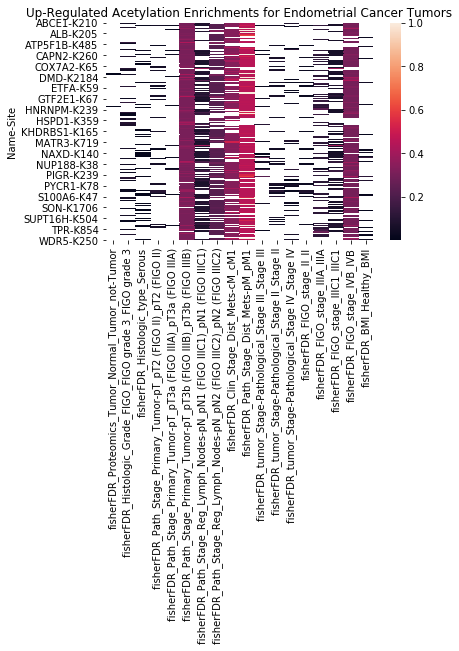

In [14]:
#Simple visualization
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Acetylation Enrichments for Endometrial Cancer Tumors')
plt.show()

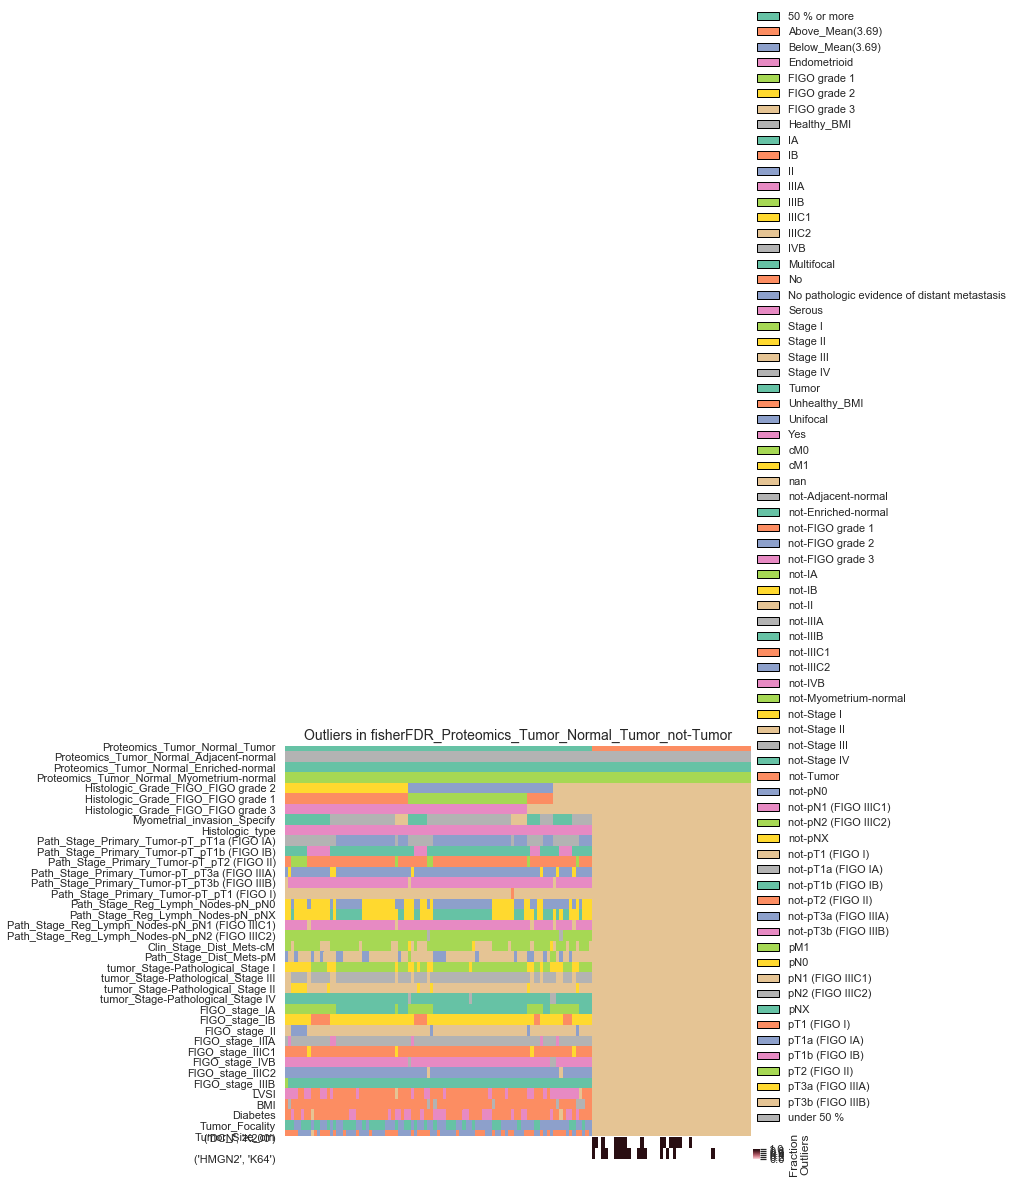

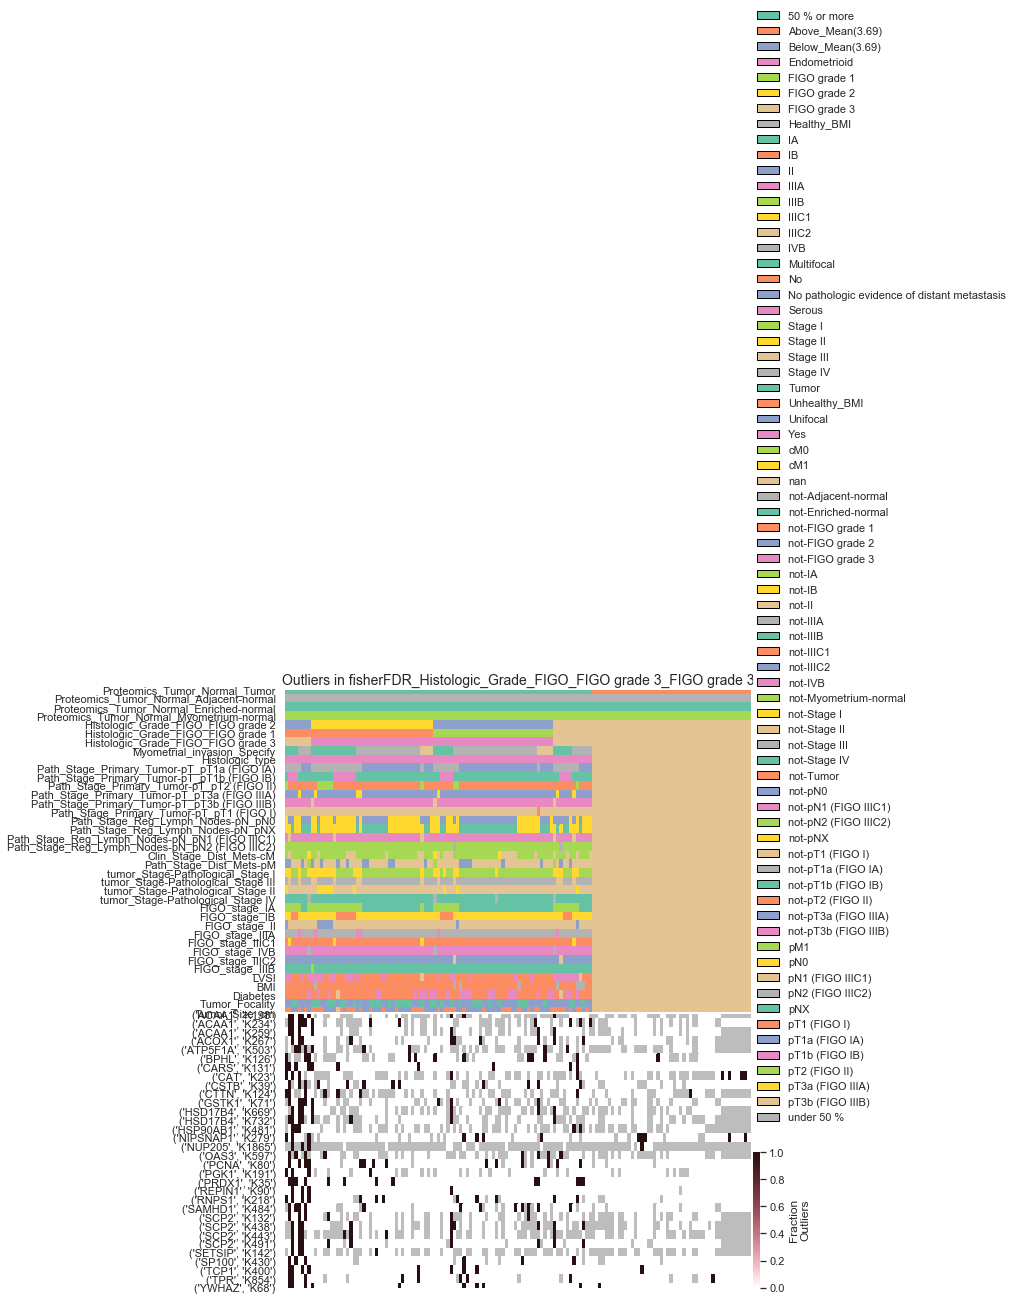

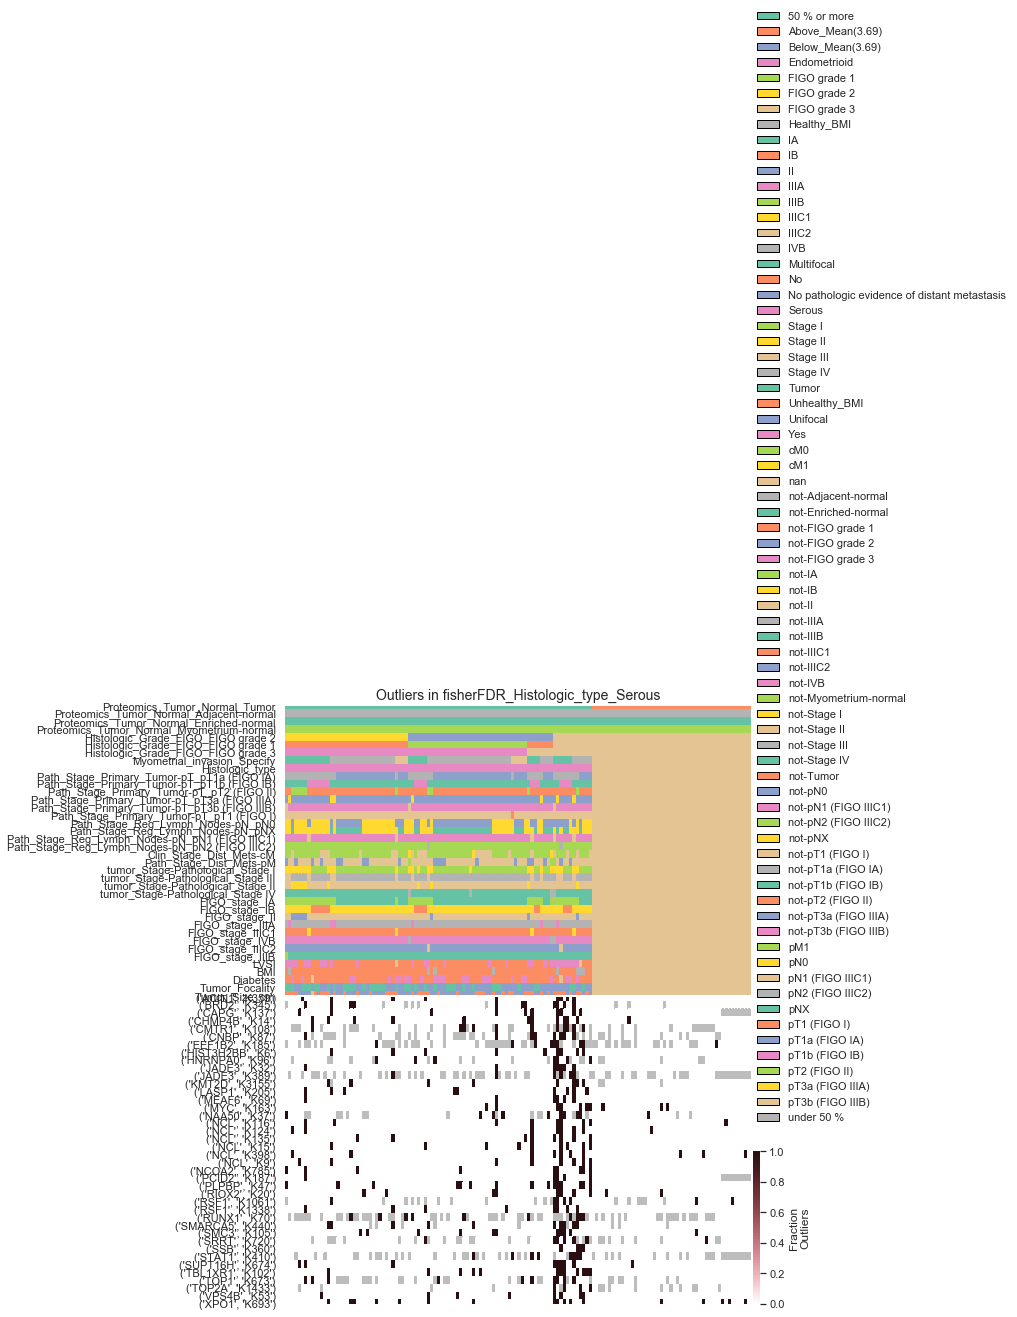

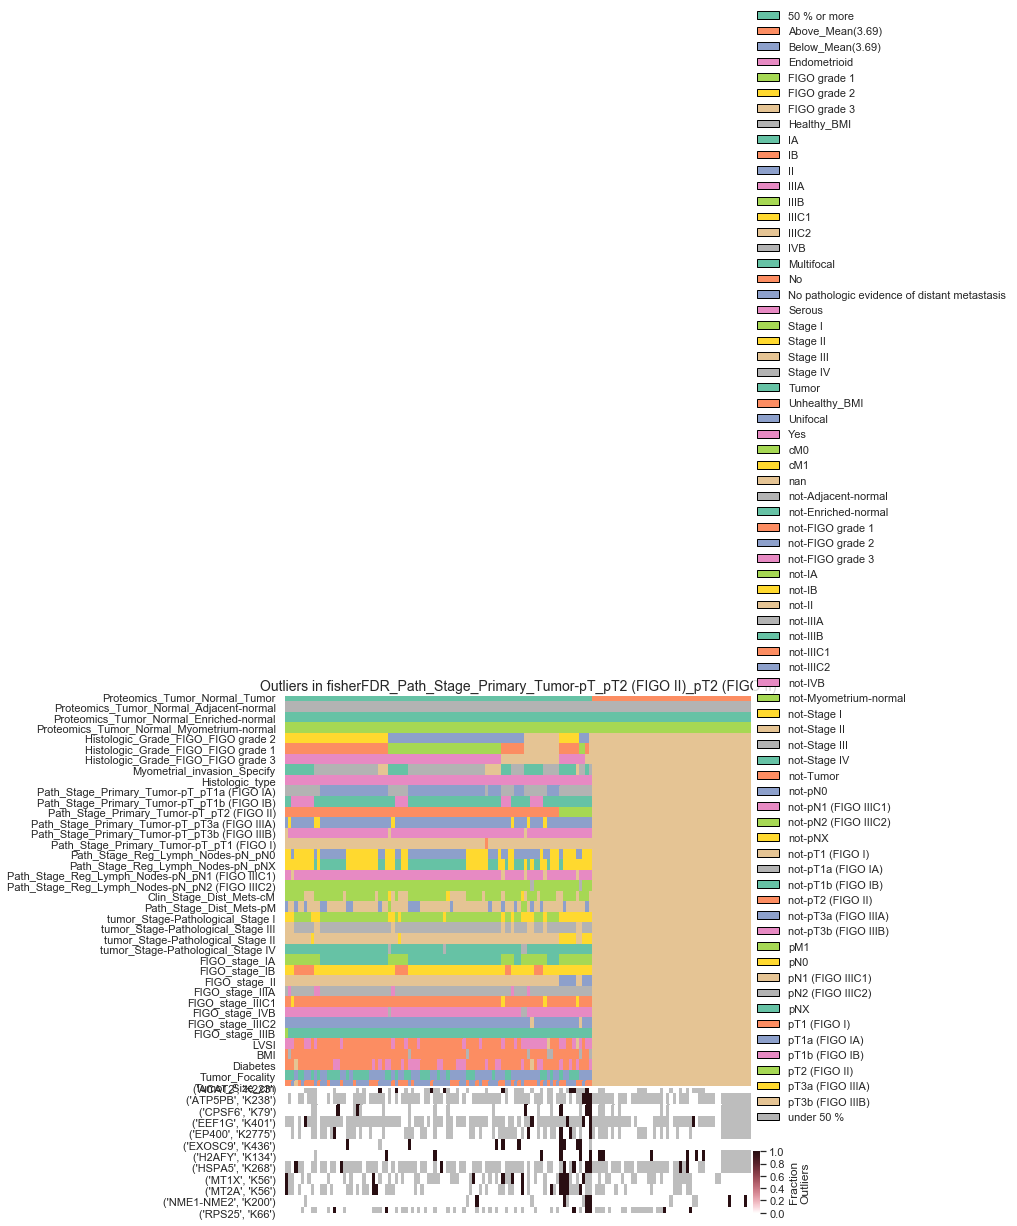

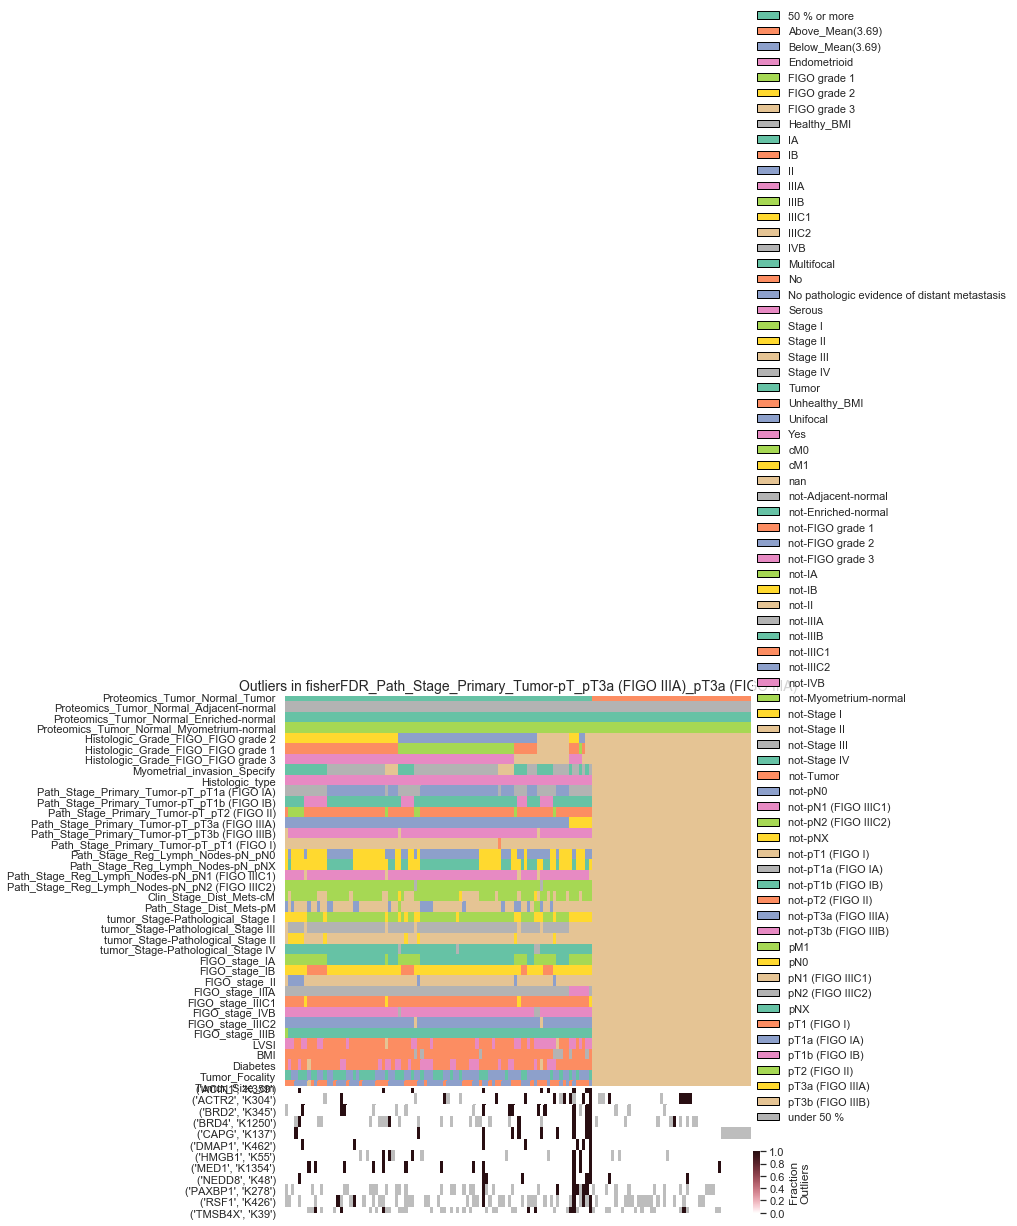

09/05/2019 17:17:57:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT3b (FIGO IIIB)_pT3b (FIGO IIIB)
09/05/2019 17:17:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN1 (FIGO IIIC1)_pN1 (FIGO IIIC1)
09/05/2019 17:17:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN2 (FIGO IIIC2)_pN2 (FIGO IIIC2)
09/05/2019 17:17:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Clin_Stage_Dist_Mets-cM_cM1
09/05/2019 17:17:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_pM1


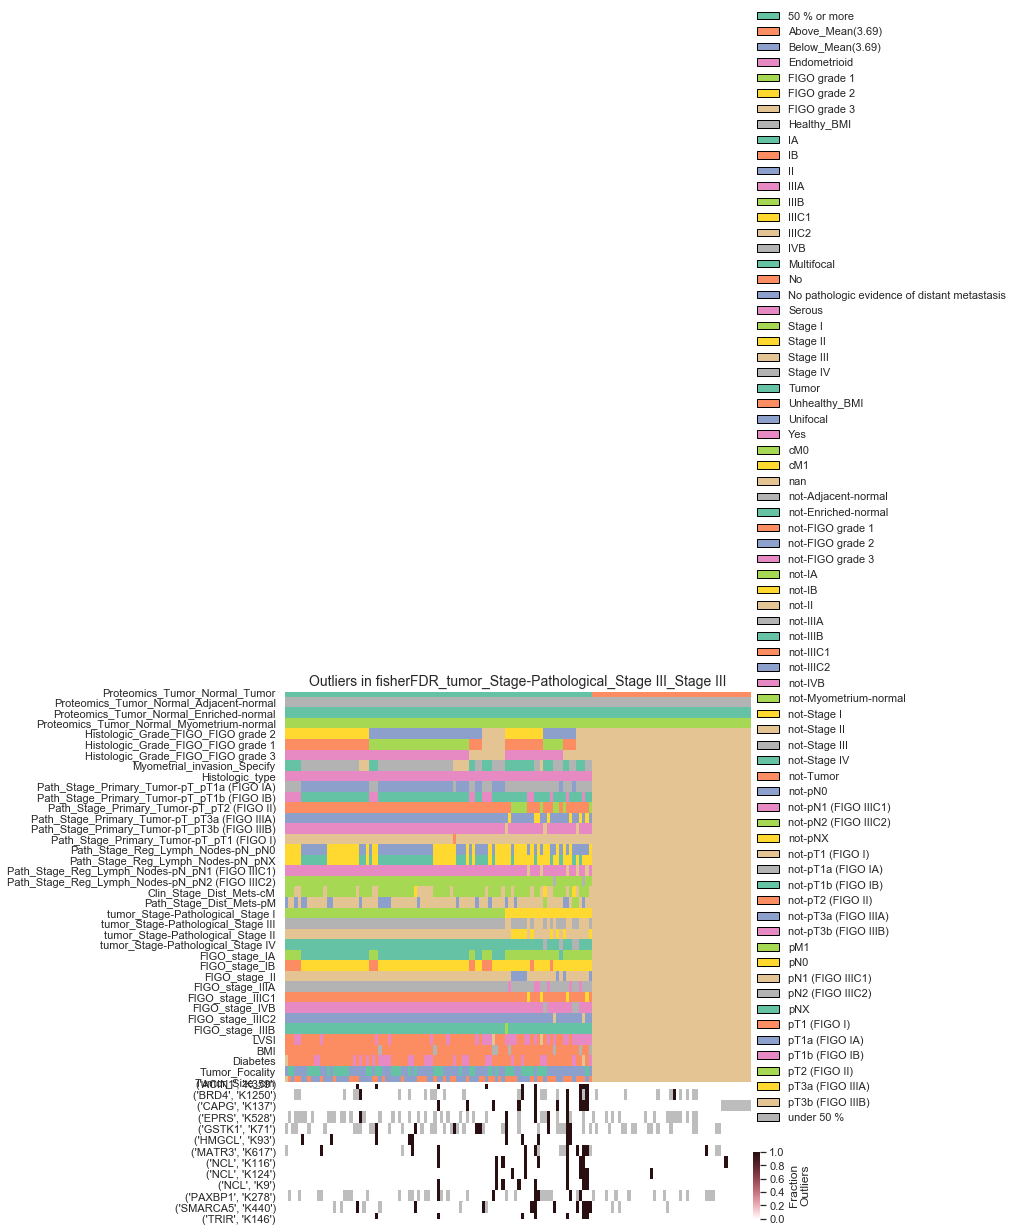

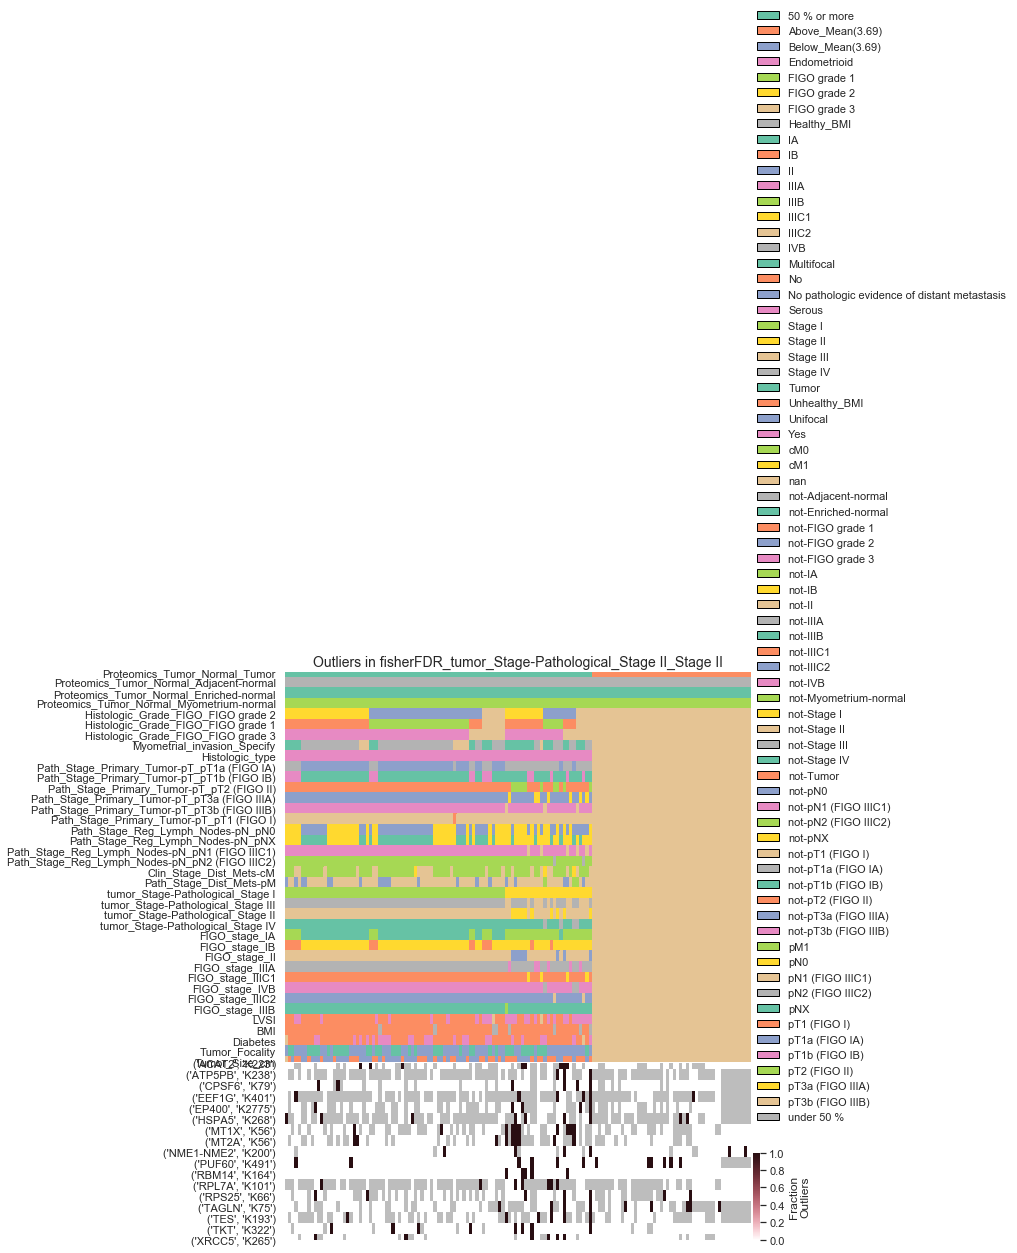

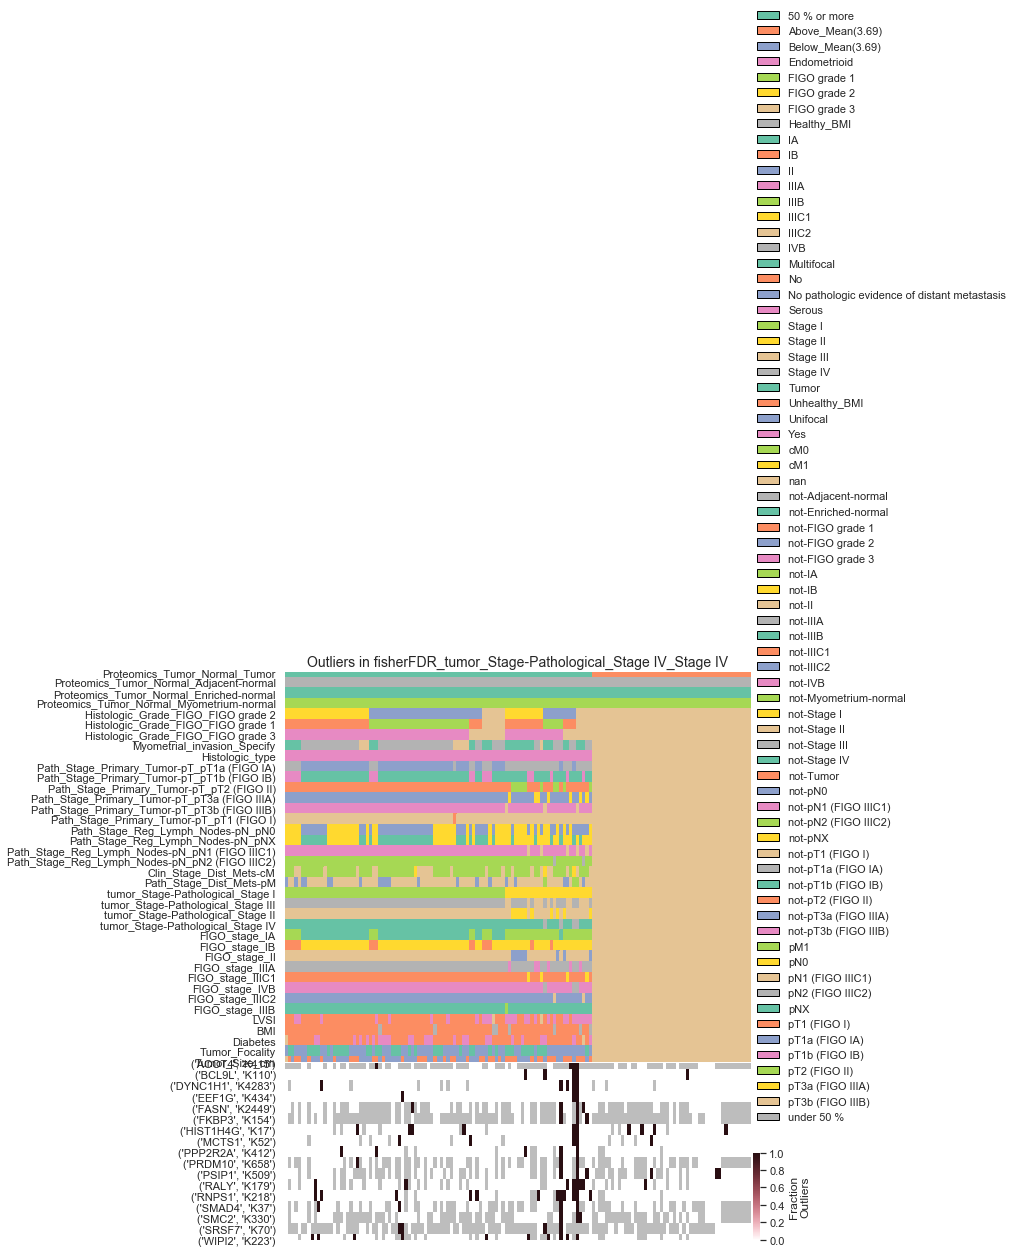

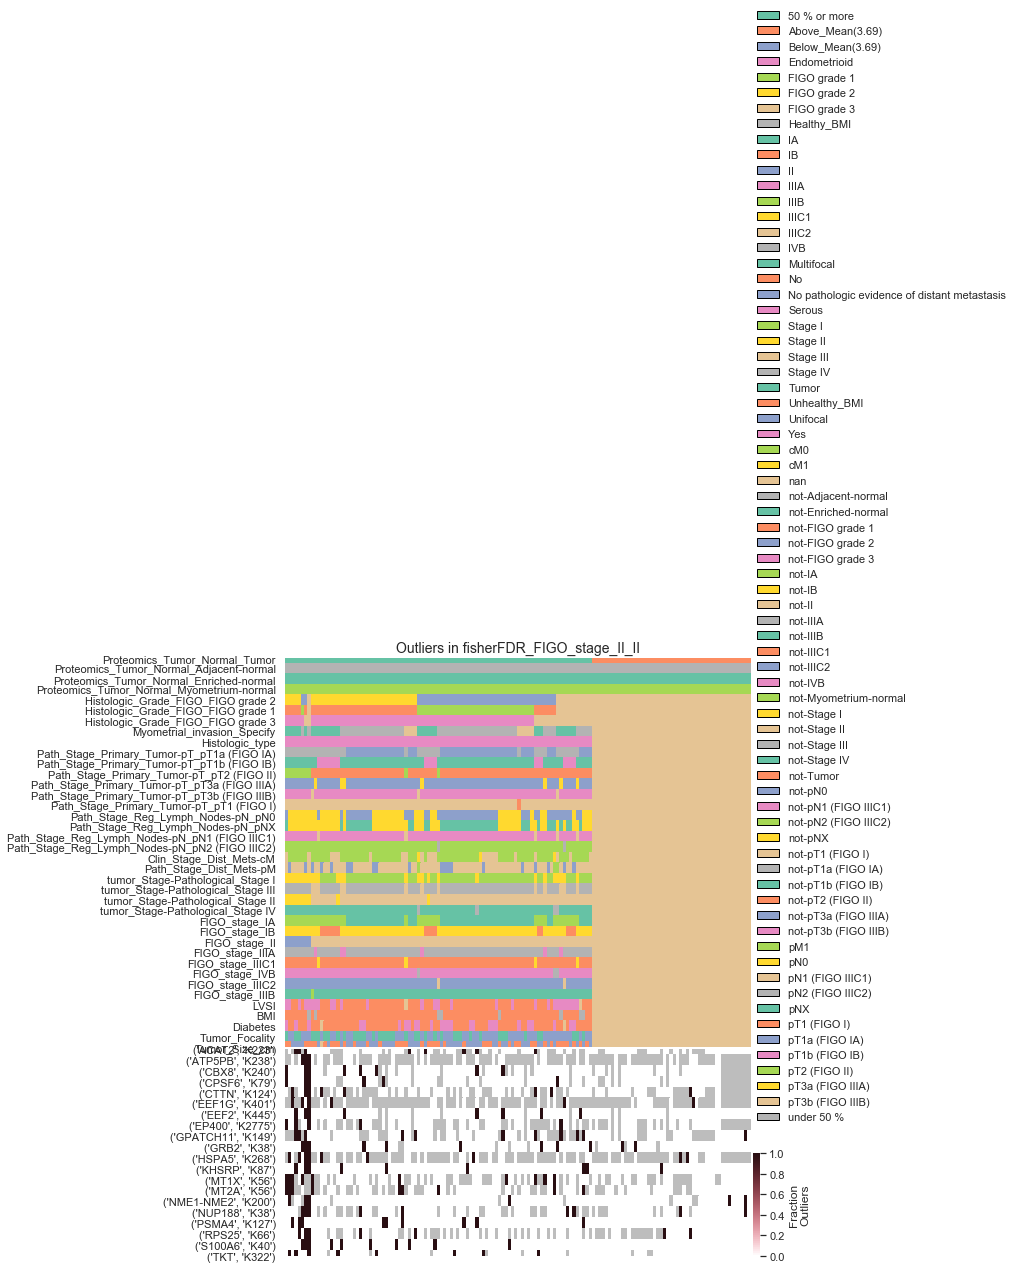

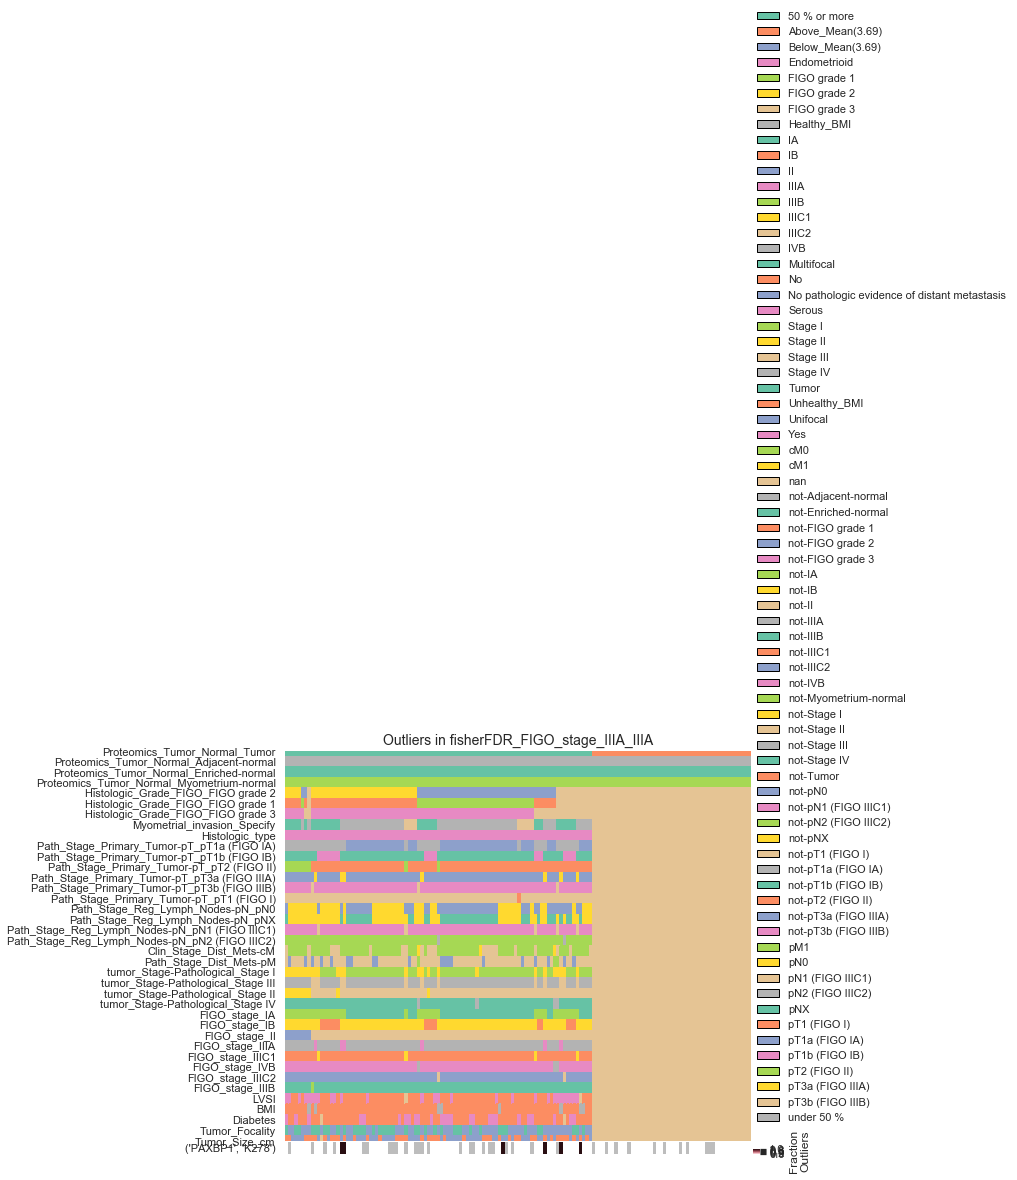

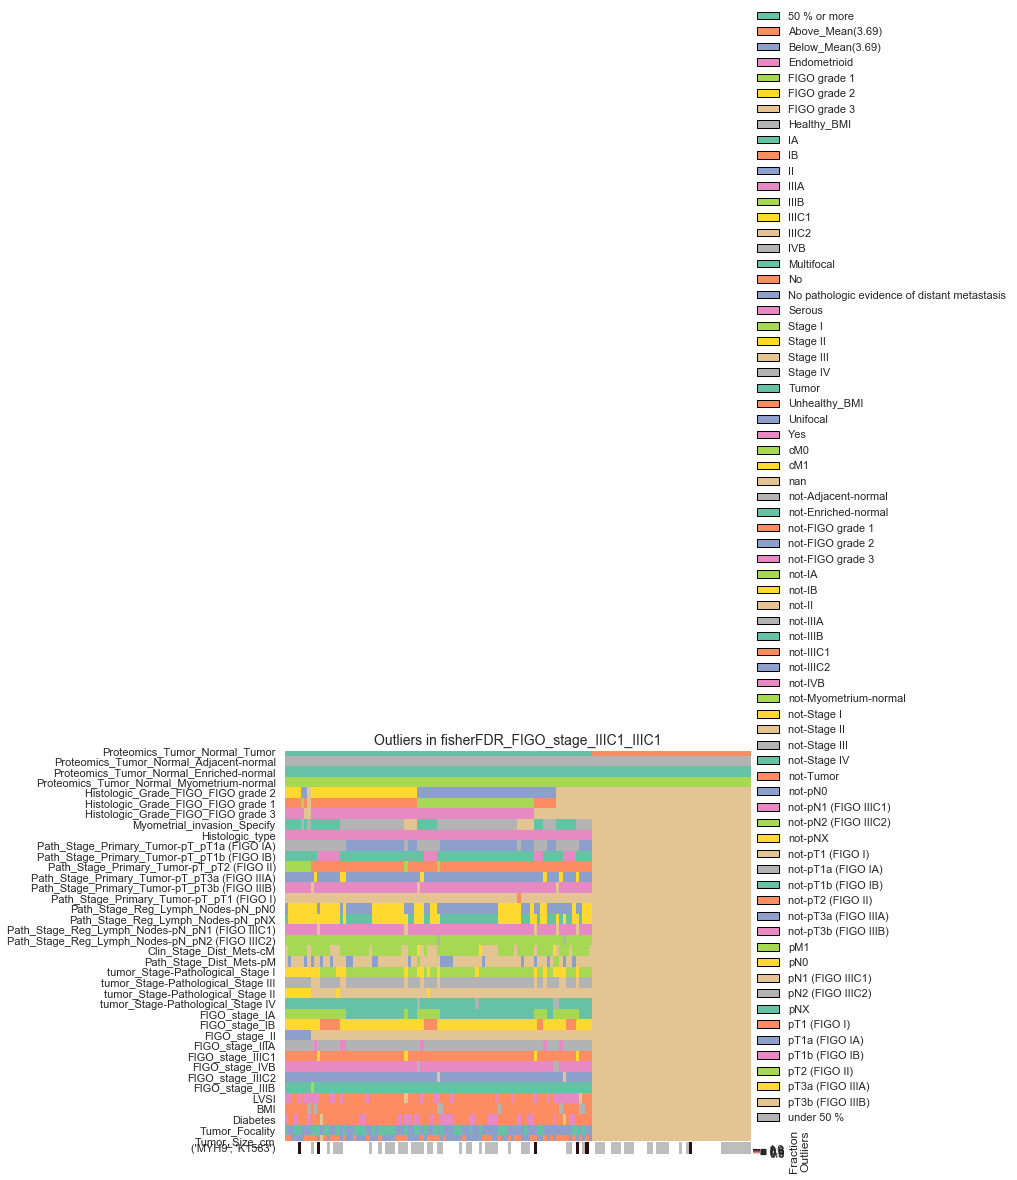

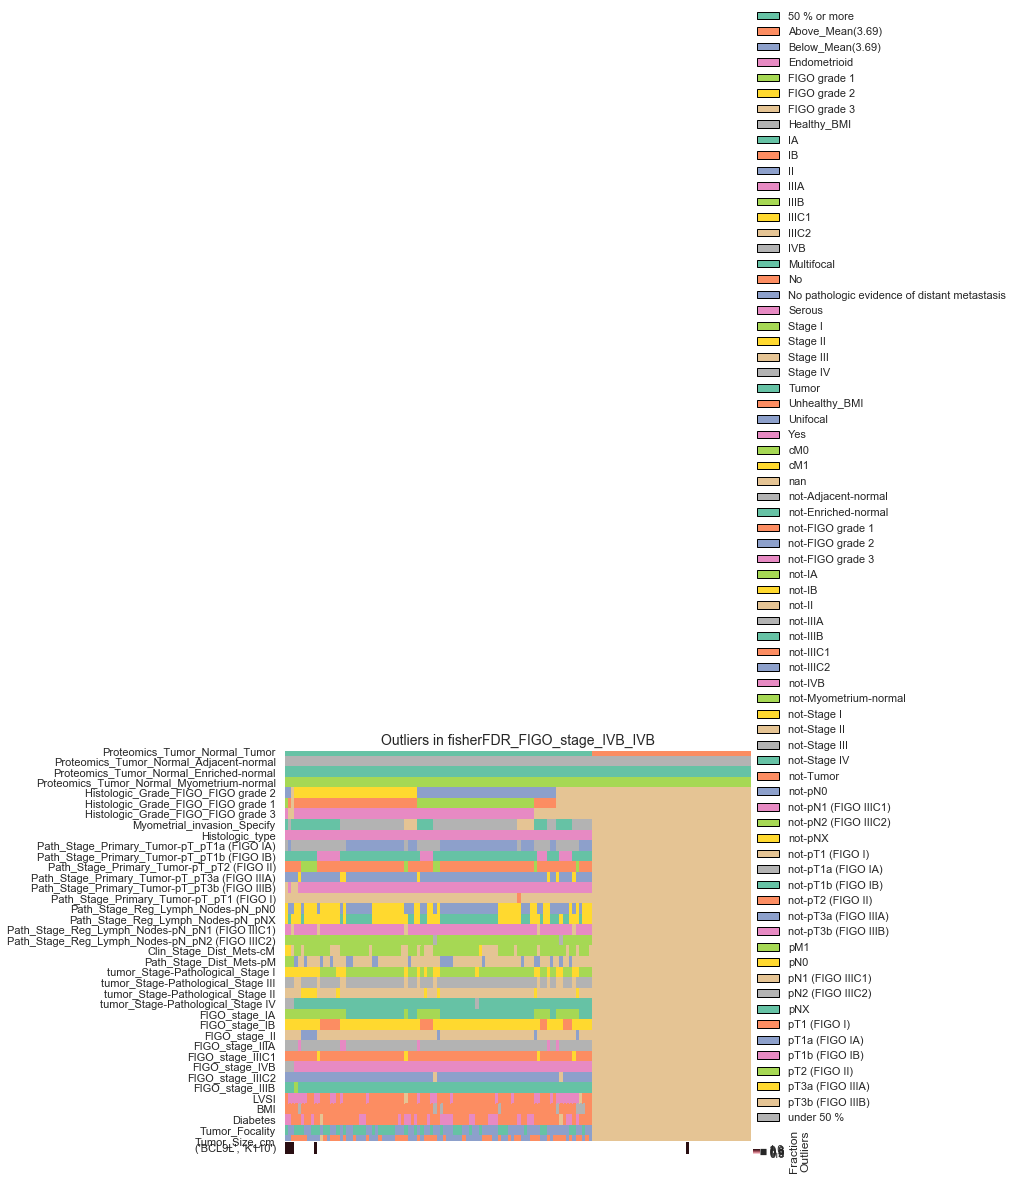

09/05/2019 17:18:38:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIC2_IIIC2


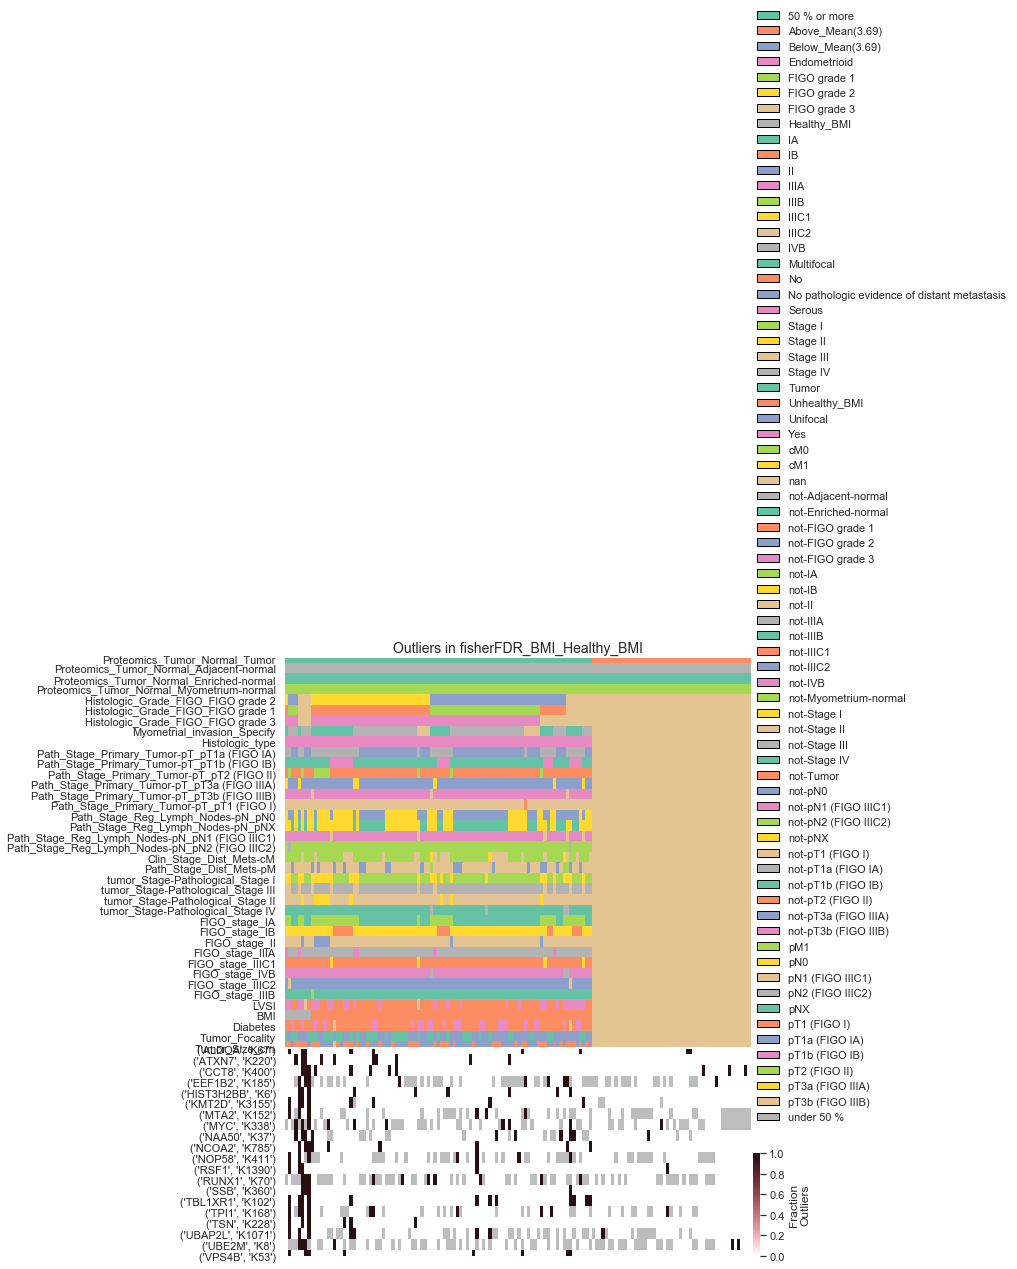

In [15]:
#Deva package visualization
for col in qvalues.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues.df,
    col_of_interest=col,
    vis_table=outliers.frac_table)
    
    plt.show()
    plt.close()

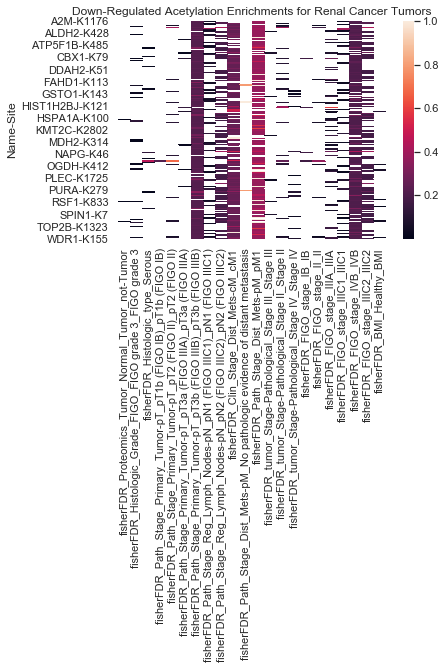

In [16]:
ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Acetylation Enrichments for Renal Cancer Tumors')
plt.show()

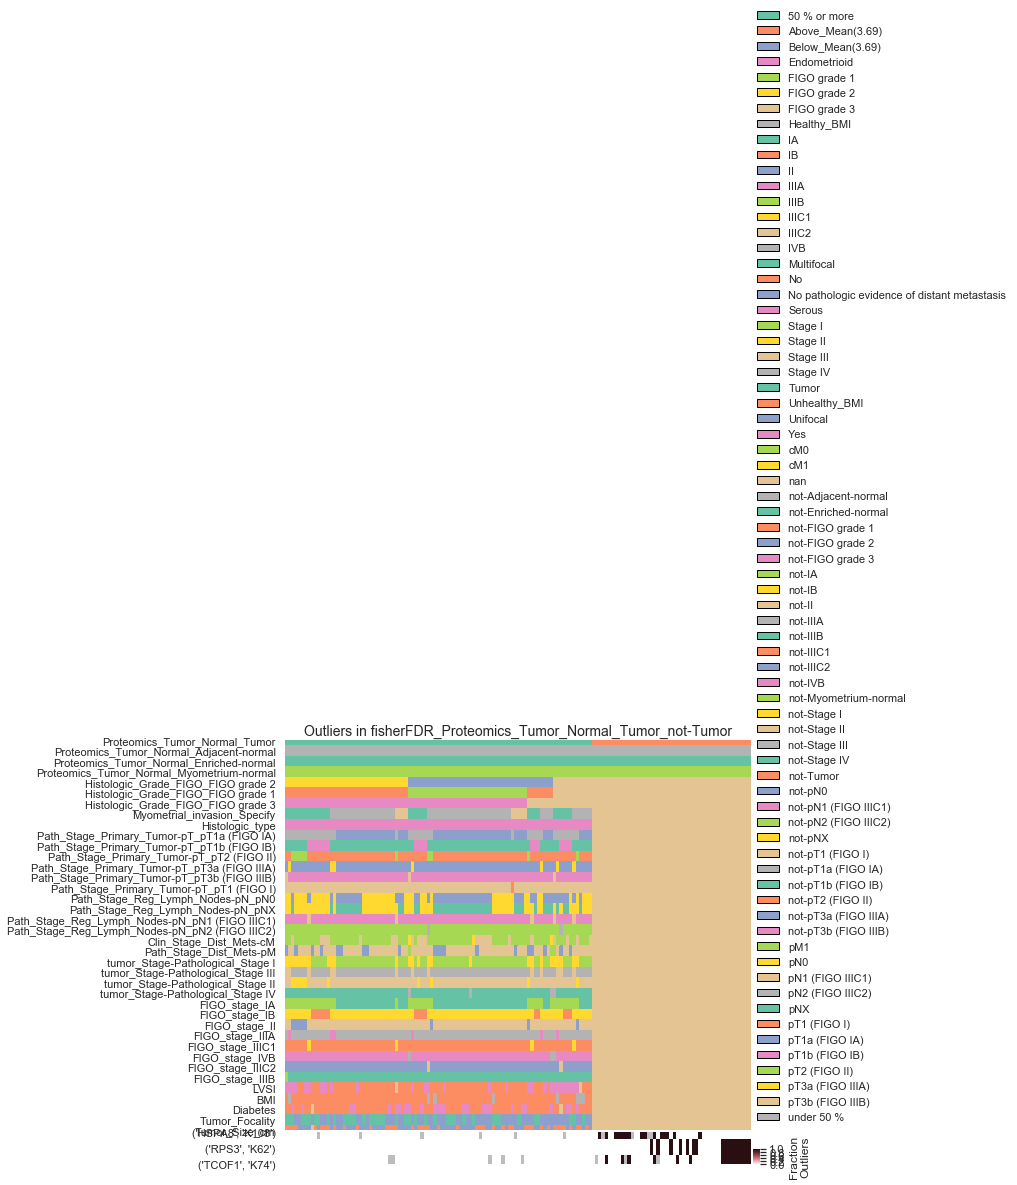

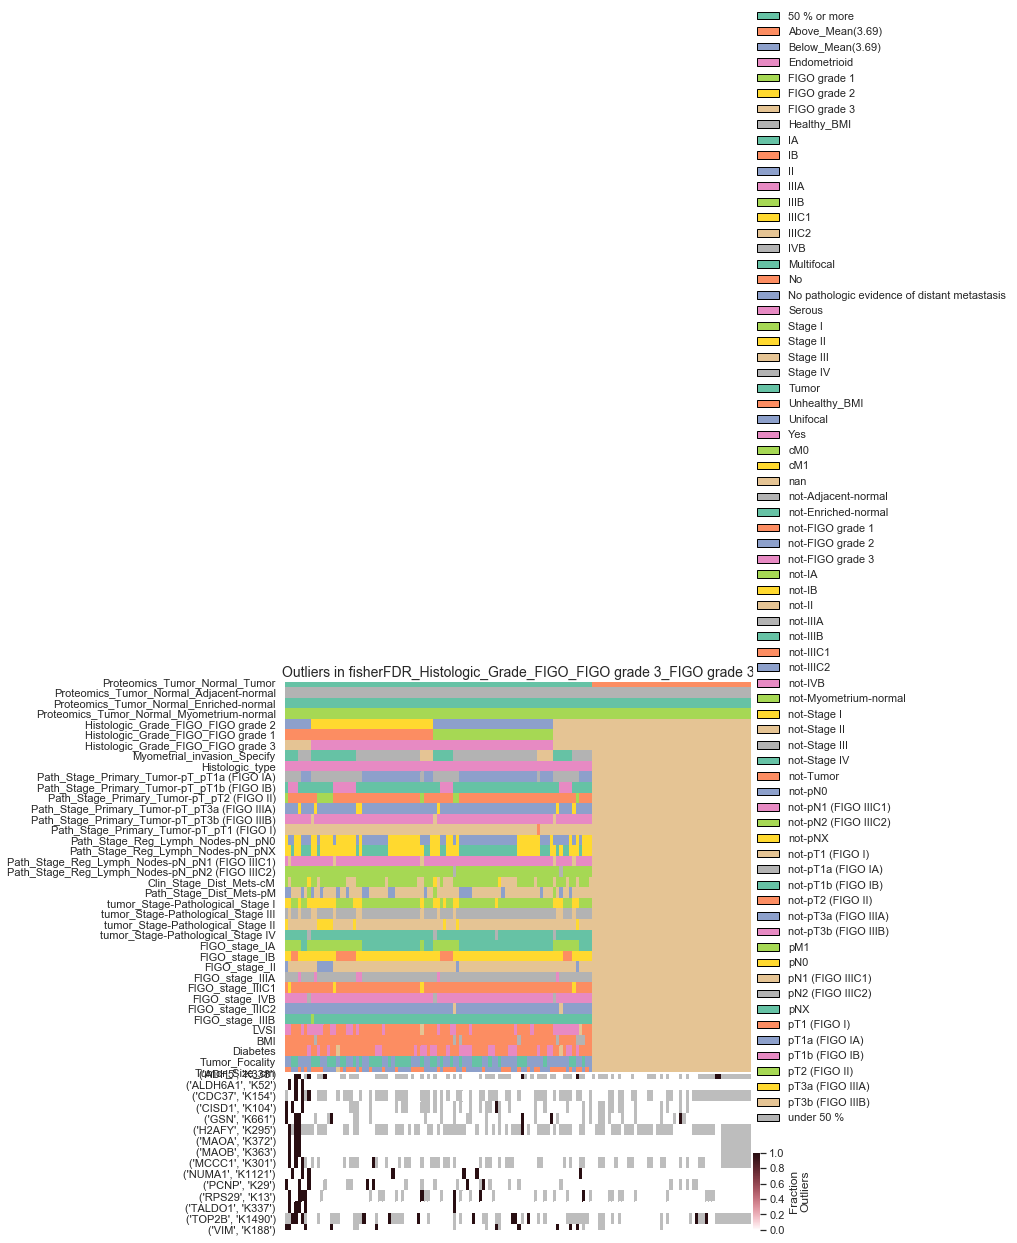

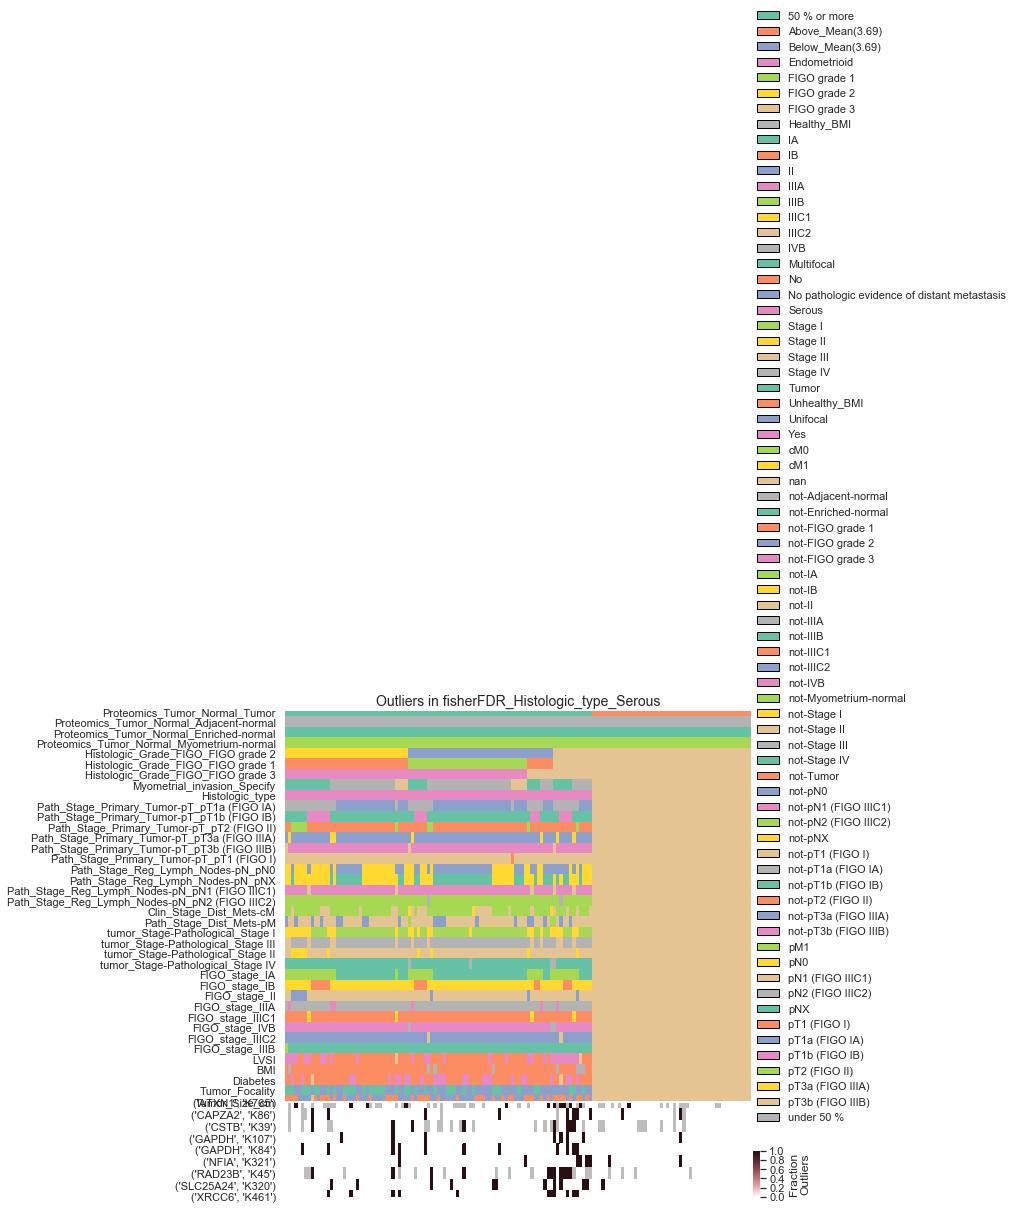

09/05/2019 17:18:54:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT1b (FIGO IB)_pT1b (FIGO IB)
09/05/2019 17:18:55:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT2 (FIGO II)_pT2 (FIGO II)


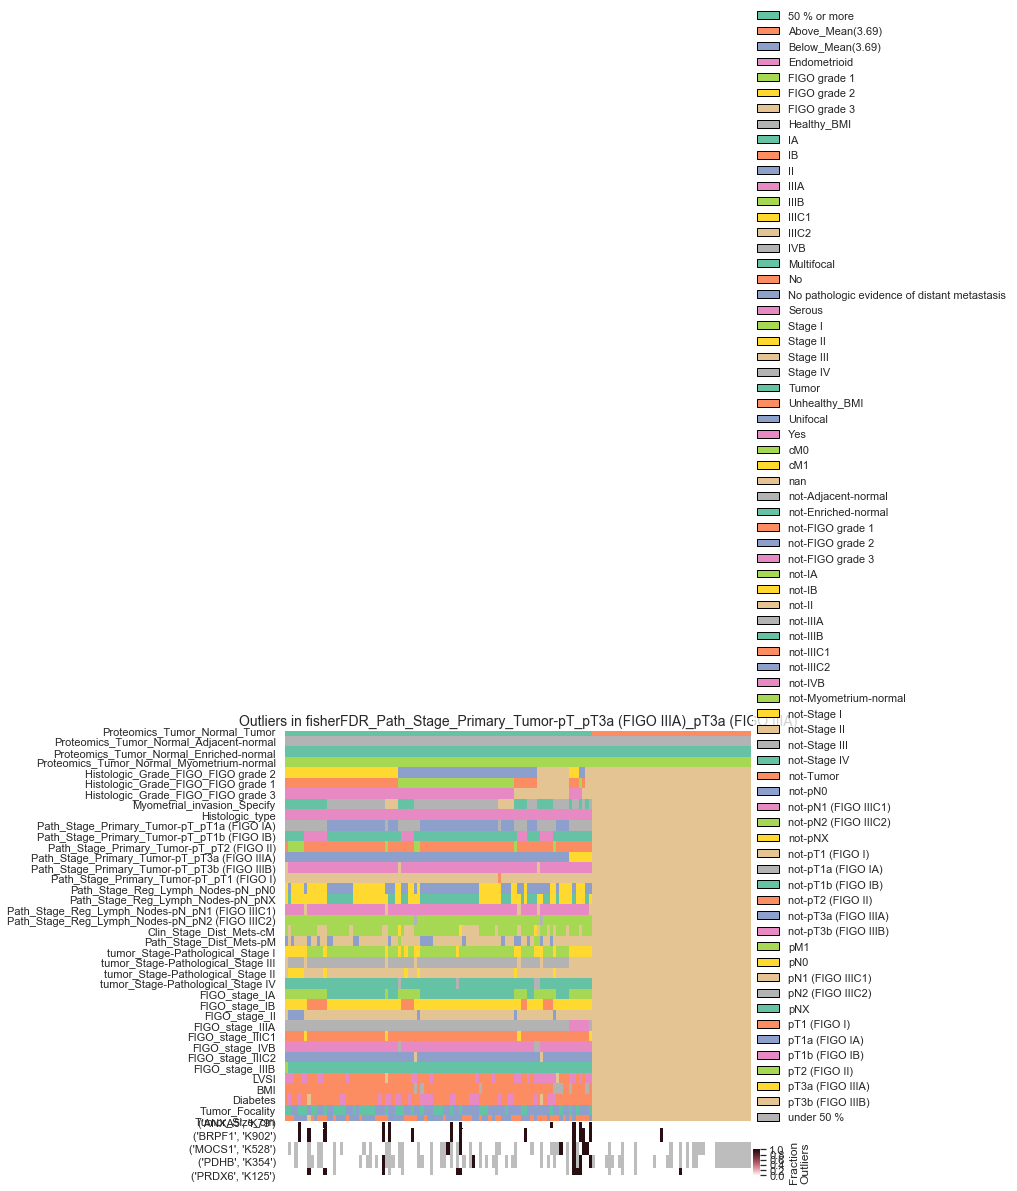

09/05/2019 17:18:59:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT3b (FIGO IIIB)_pT3b (FIGO IIIB)


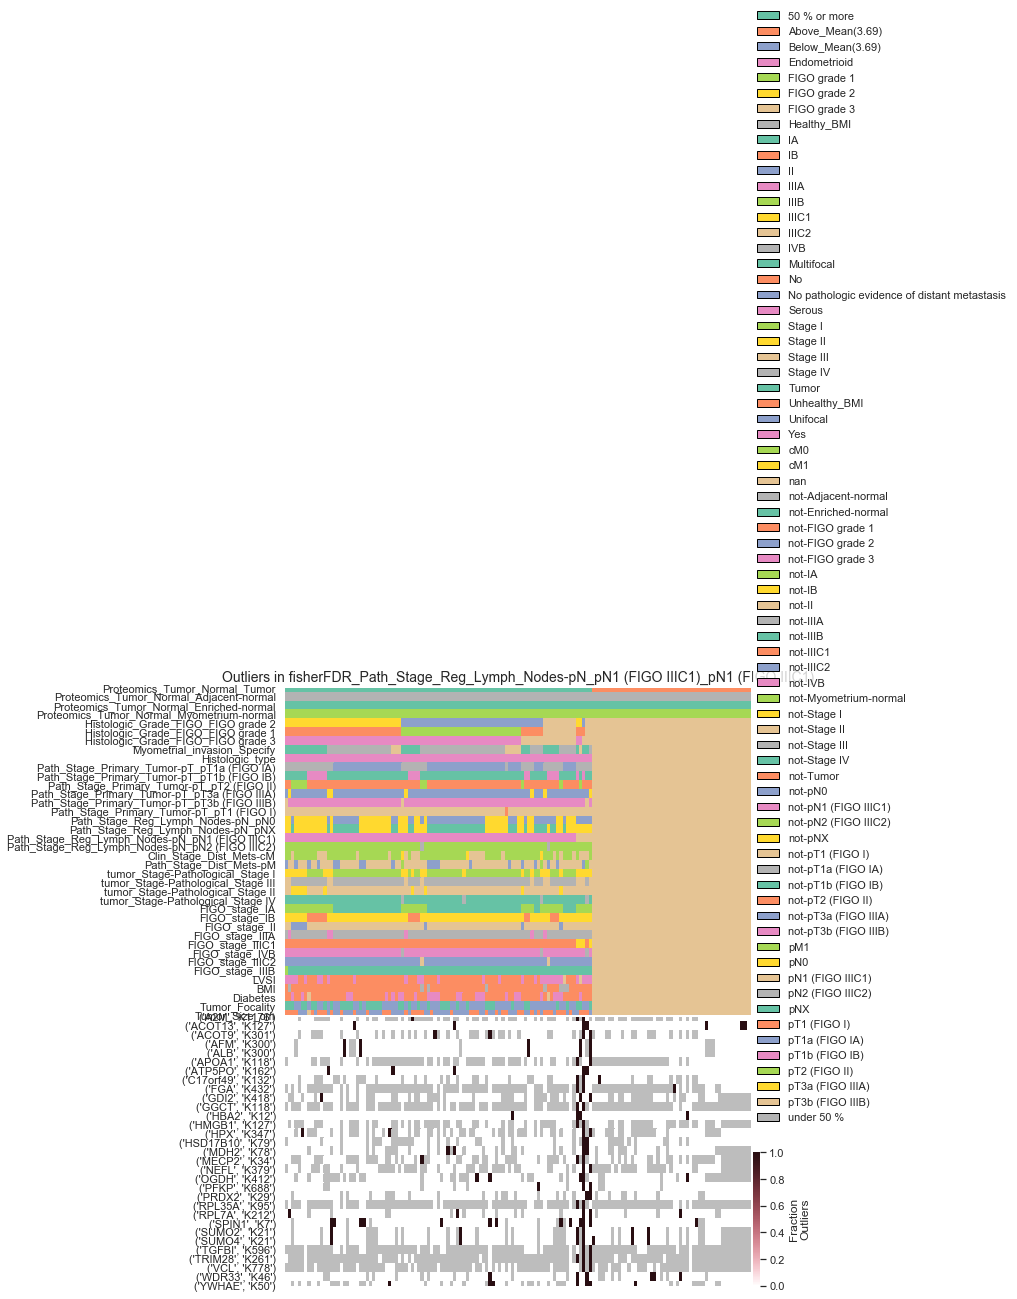

09/05/2019 17:19:06:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN2 (FIGO IIIC2)_pN2 (FIGO IIIC2)
09/05/2019 17:19:06:WARNING:No significant genes at FDR 0.05 in fisherFDR_Clin_Stage_Dist_Mets-cM_cM1
09/05/2019 17:19:06:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_No pathologic evidence of distant metastasis
09/05/2019 17:19:07:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_pM1


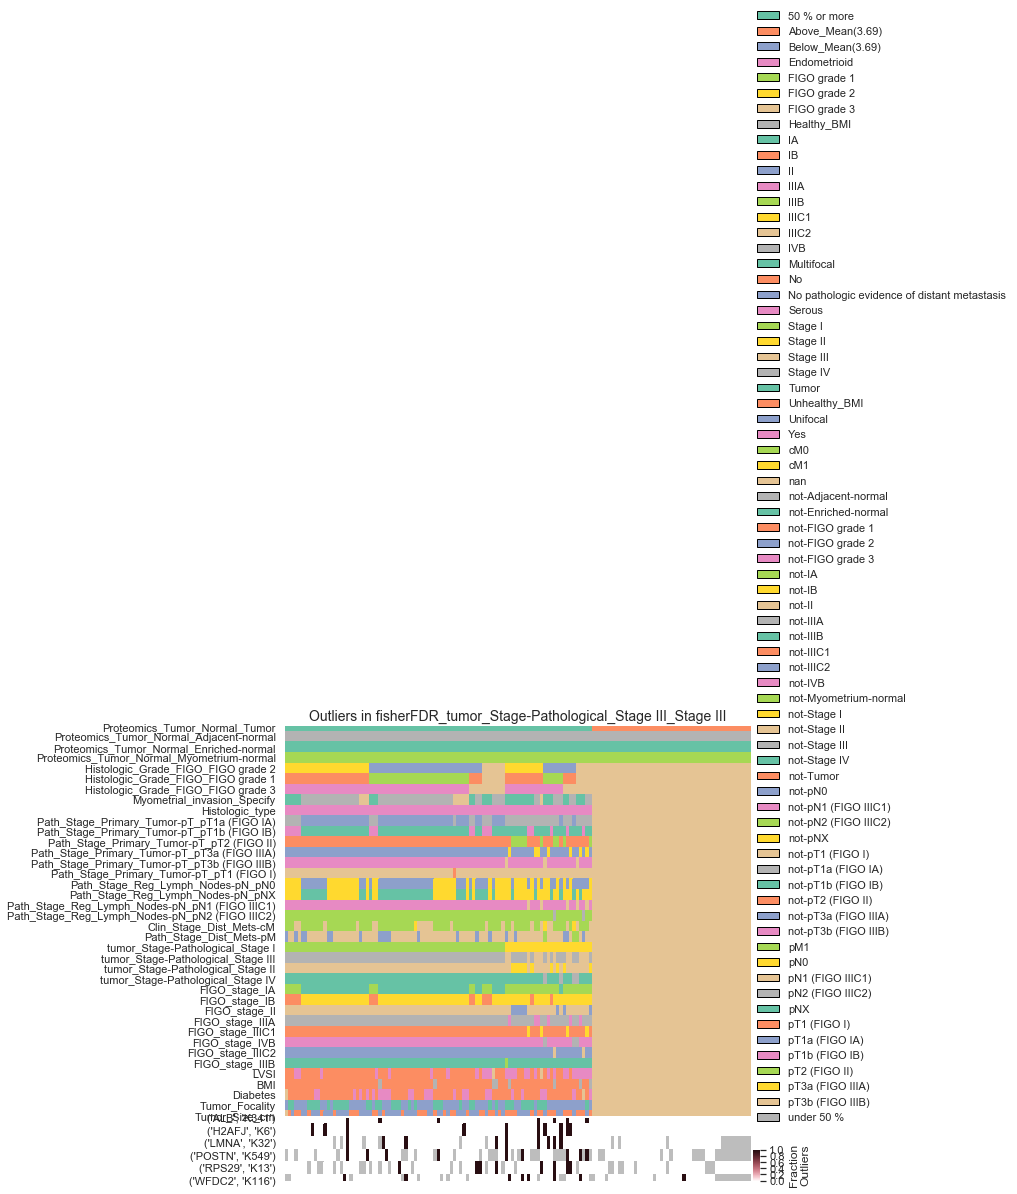

09/05/2019 17:19:13:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_Stage-Pathological_Stage II_Stage II


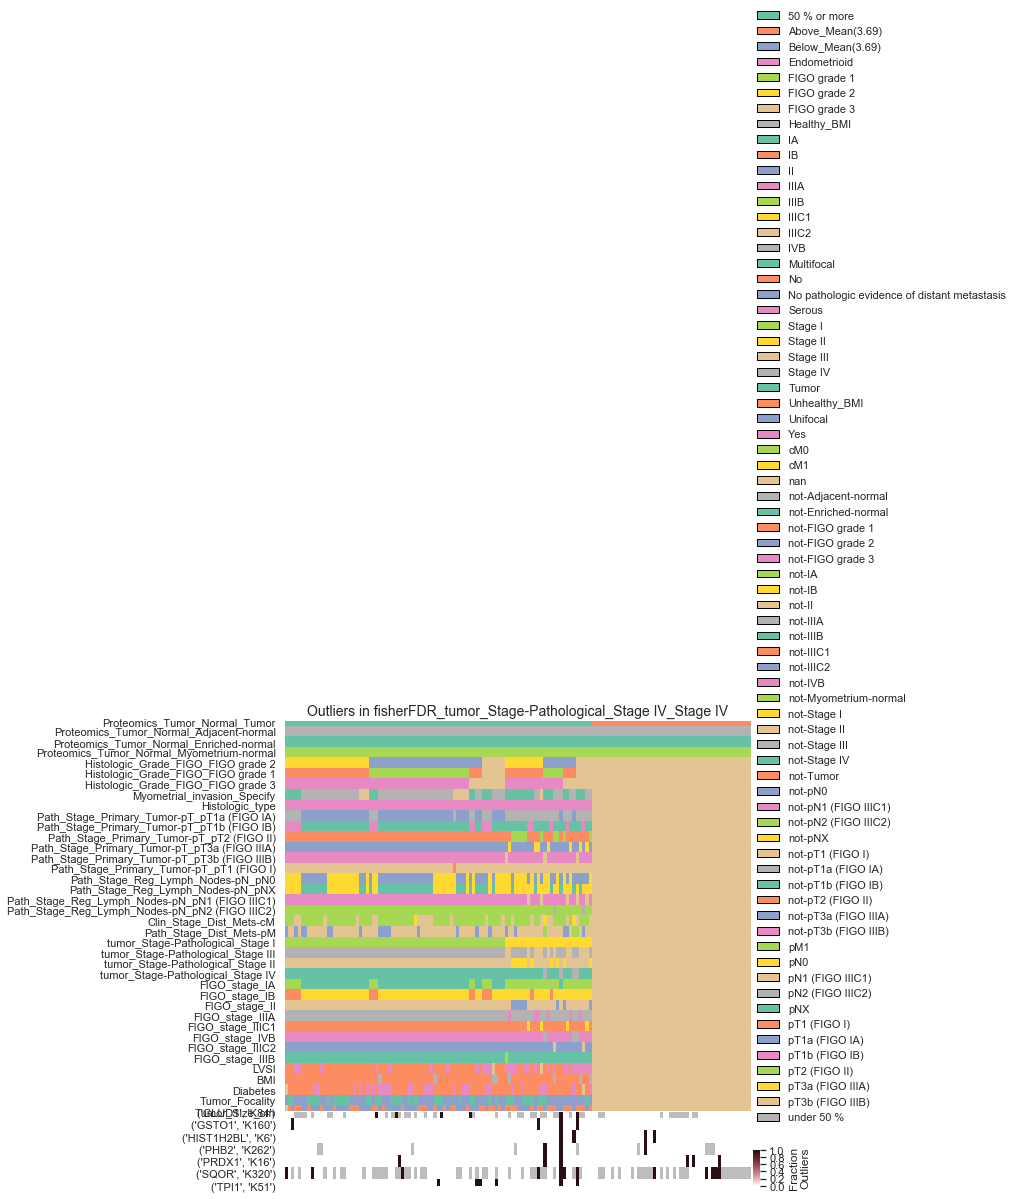

09/05/2019 17:19:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IB_IB


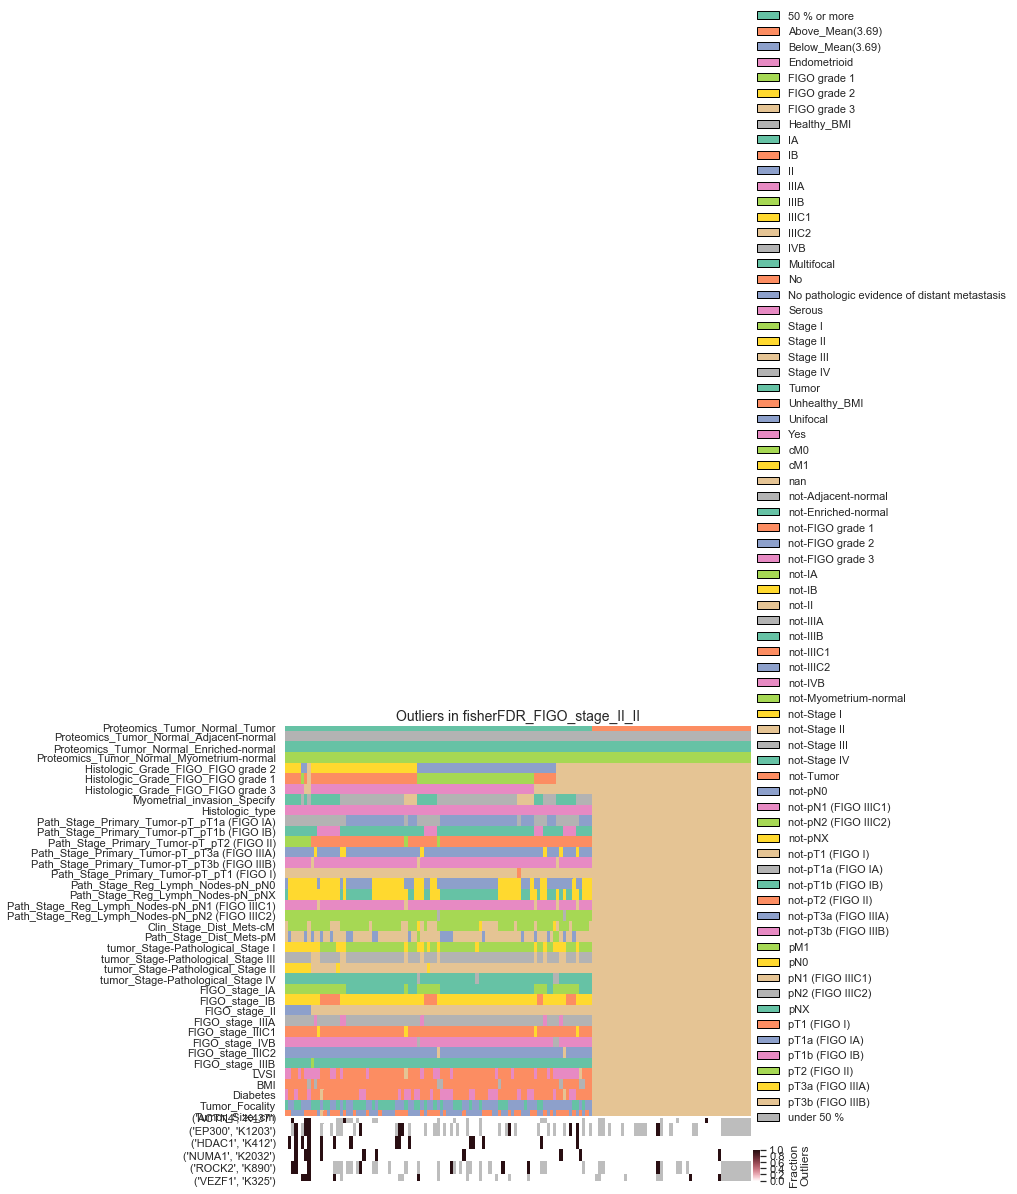

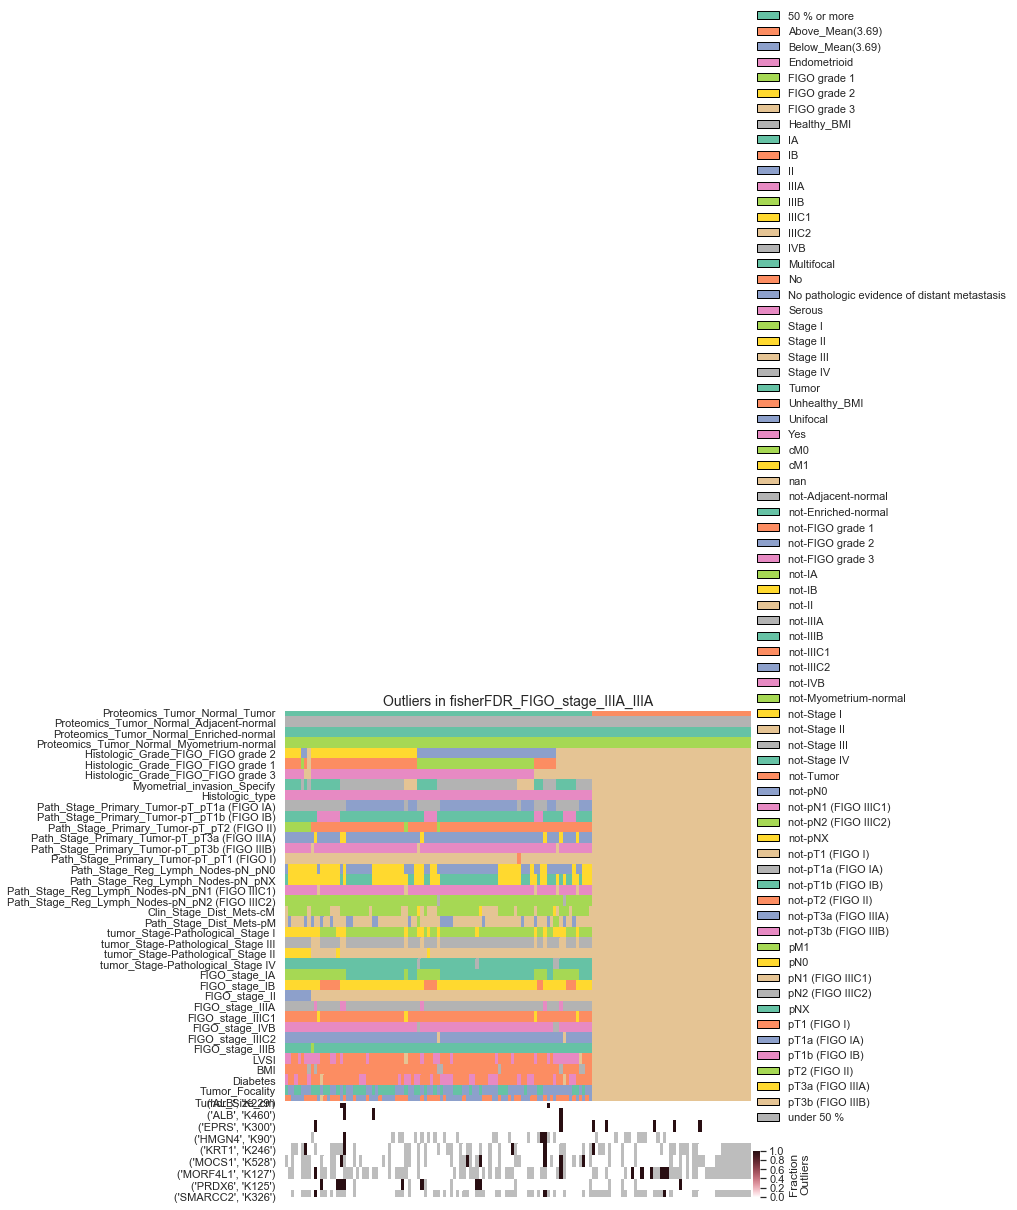

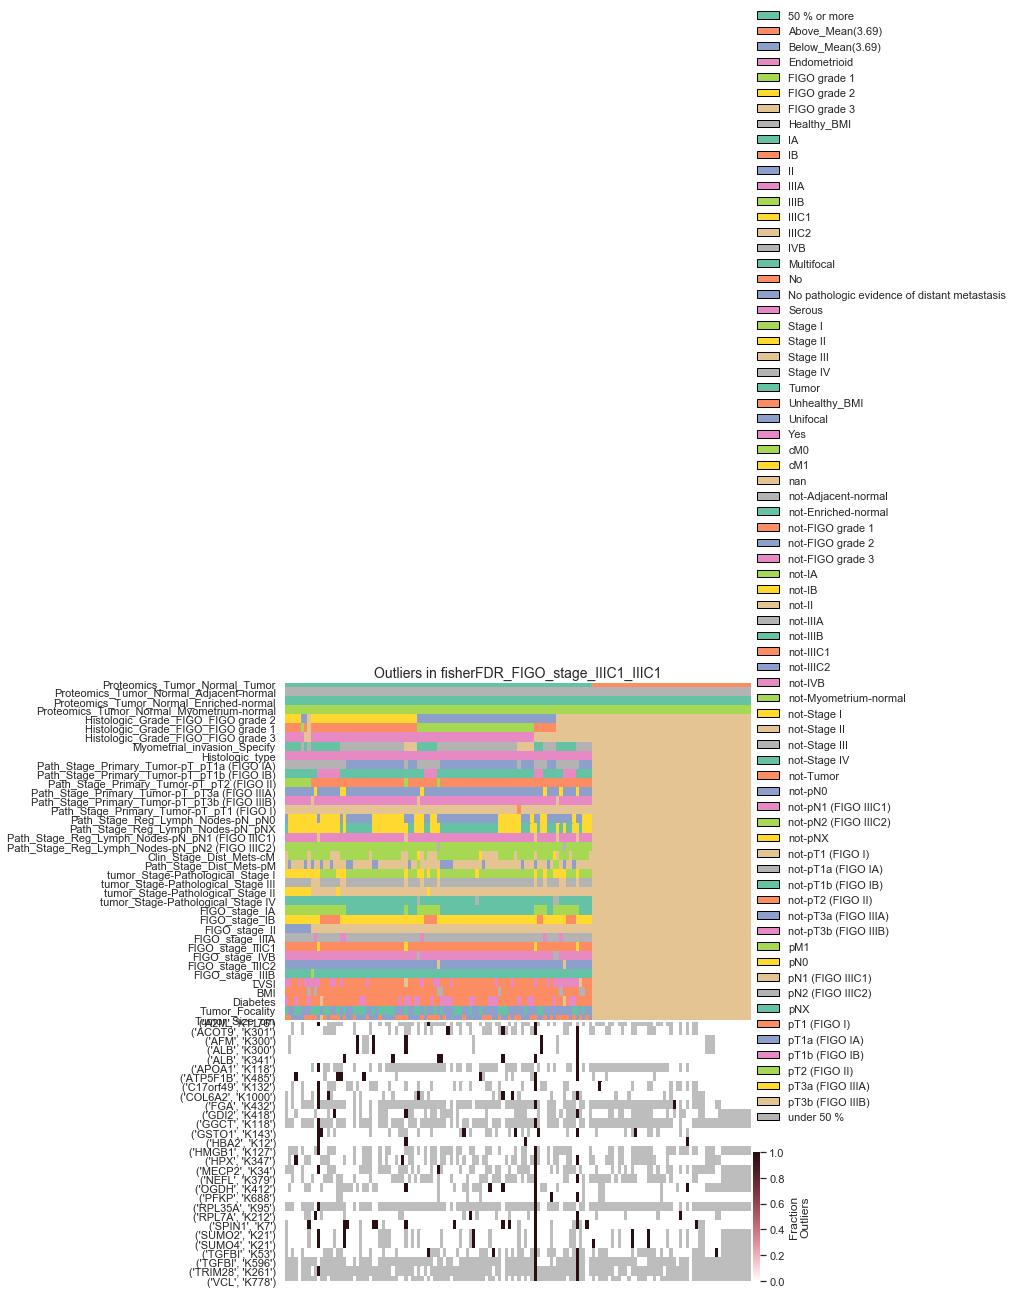

09/05/2019 17:19:32:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IVB_IVB
09/05/2019 17:19:32:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIC2_IIIC2


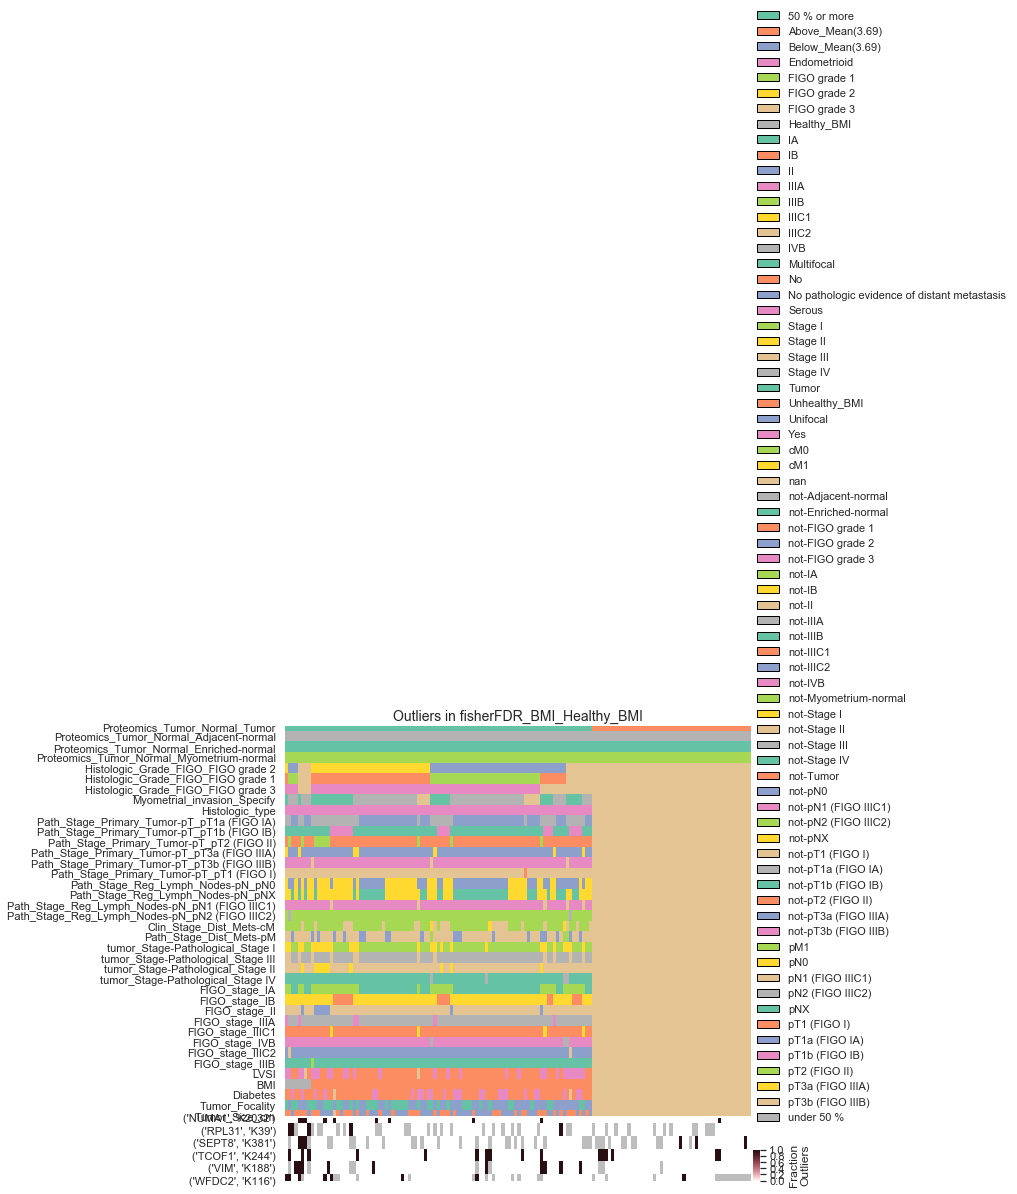

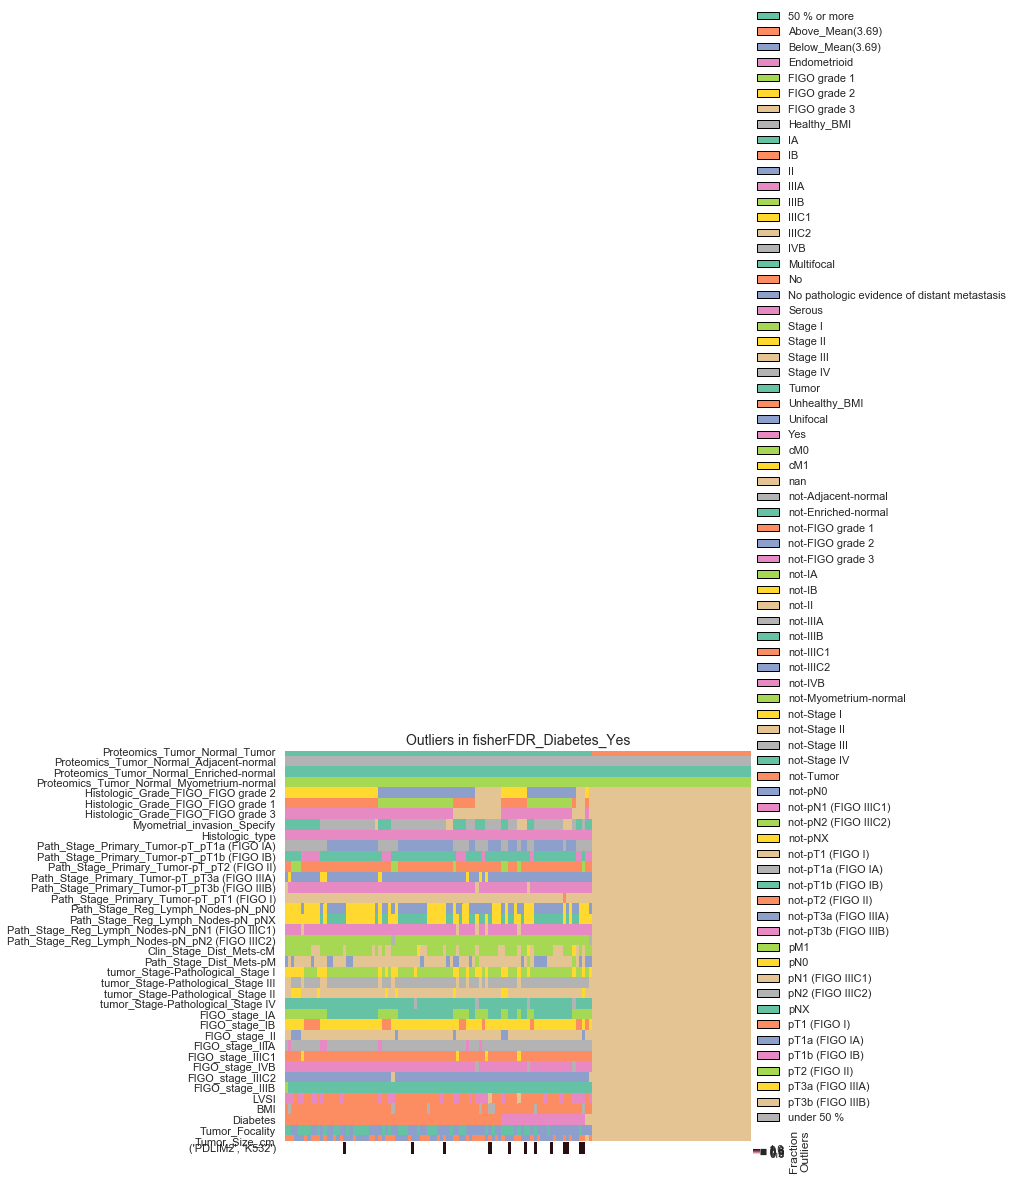

In [17]:
#Deva package visualization
for col in qvalues_down.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues_down.df,
    col_of_interest=col,
    vis_table=outliers_down.frac_table)
    
    plt.show()
    plt.close()

## Step 5: Perform Gene Set Enrichment Analysis

Part A: Up-regulated Genes

In [19]:
#What am I going to do with all the sites and multi-indexes?
sig_cols_up

[                Histologic_Grade_FIGO_FIGO grade 3_FIGO grade 3_P_values
 Name     Site                                                           
 ACAA1    K198                                            0.017925       
          K234                                            0.017925       
          K259                                            0.049732       
 ACOX1    K267                                            0.049812       
 ATP5F1A  K503                                            0.028963       
 BPHL     K126                                            0.049732       
 CARS     K131                                            0.017925       
 CAT      K23                                             0.028963       
 CSTB     K39                                             0.049732       
 CTTN     K124                                            0.045424       
 GSTK1    K71                                             0.028963       
 HSD17B4  K669                        

In [18]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(col.index)
    print('Gene List:', gene_name_list, '\n')
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/endo')
    gsea_up[col_name] = enrichment
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3
Gene List: [('ACAA1', 'K198'), ('ACAA1', 'K234'), ('ACAA1', 'K259'), ('ACOX1', 'K267'), ('ATP5F1A', 'K503'), ('BPHL', 'K126'), ('CARS', 'K131'), ('CAT', 'K23'), ('CSTB', 'K39'), ('CTTN', 'K124'), ('GSTK1', 'K71'), ('HSD17B4', 'K669'), ('HSD17B4', 'K732'), ('HSP90AB1', 'K481'), ('NIPSNAP1', 'K279'), ('NUP205', 'K1865'), ('OAS3', 'K597'), ('PCNA', 'K80'), ('PGK1', 'K191'), ('PRDX1', 'K35'), ('REPIN1', 'K90'), ('RNPS1', 'K218'), ('SAMHD1', 'K484'), ('SCP2', 'K132'), ('SCP2', 'K438'), ('SCP2', 'K443'), ('SCP2', 'K491'), ('SETSIP', 'K142'), ('SP100', 'K430'), ('TCP1', 'K400'), ('TPR', 'K854'), ('YWHAZ', 'K68')] 



TypeError: sequence item 0: expected str instance, tuple found

Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, and then for patients with invasive carcinoma.

In [ ]:
gsea_sig_attributes = ['Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3', 
                       'Histologic_type_Serous', 
                       'Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)']

gsea_sig_up_dict = {}

for attribute in gsea_sig_attributes:
    attribute += '_P_values'
    temp_df = gsea_up[attribute].res2d
    sig_filter = temp_df['Adjusted P-value'] < 0.05
    sig_terms = temp_df[sig_filter]
    gsea_sig_up_dict[attribute] = sig_terms
    print(attribute)
    print(gsea_sig_up_dict[attribute][['Term', 'Overlap', 'Adjusted P-value']])
    print('\n')

In [ ]:
for k, v in gsea_sig_up_dict.items():
    print(k)
    print(v[['Term', 'Overlap', 'Adjusted P-value']])
    print('\n')

In [ ]:
gsea_terms_and_genes = {}

for attribute, vals in gsea_sig_up_dict.items():
    genes = vals['Genes']
    terms = vals['Term']
    terms_and_genes = {}
    for i, gene in enumerate(genes):
        terms_and_genes[terms[i]] = gene.split(';')
    gsea_terms_and_genes[attribute] = terms_and_genes

In [ ]:
figo3_dict = gsea_terms_and_genes['Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3_P_values']
figo3_dict

In [ ]:
serous_dict = gsea_terms_and_genes['Histologic_type_Serous_P_values']
serous_dict

In [ ]:
path_stage_pT3a = gsea_terms_and_genes['Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)_P_values']
path_stage_pT3a

## Step 6: Connect Findings with Druggable Genome Interactive Database (DGIdb)

In [27]:
figo3_requests = {}
figo3_requests_parsed = {}
for term, gene_list in figo3_dict.items():
    figo3_requests[term] = bf.dgidb_get_request(gene_list)
    figo3_requests_parsed[term] = bf.dgidb_json_parse(figo3_requests[term], genes=True)

print(json.dumps(figo3_requests_parsed, indent=4))

{
    "Ferroptosis": {
        "SLC11A2": {
            "CHEMBL259327": [
                "inhibitor"
            ]
        },
        "TP53": {
            "ASPIRIN": [
                "acetylation"
            ],
            "BORTEZOMIB": [
                "inhibitor"
            ],
            "HALOPERIDOL": [],
            "AMG-900": [],
            "EPIRUBICIN": [],
            "DABRAFENIB": [],
            "BEVACIZUMAB": [],
            "INK-128": [],
            "PROXYPHYLLINE": [],
            "DIETHYLSTILBESTROL": [],
            "AZD-6738": [],
            "STREPTONIGRIN": [],
            "Lesogaberan": [],
            "GEDATOLISIB": [],
            "URSODIOL": [],
            "DECITABINE": [],
            "PRAMLINTIDE": [],
            "IRINOTECAN": [],
            "TRAMETINIB": [],
            "DAUNORUBICIN": [],
            "ERLOTINIB": [],
            "SELICICLIB": [],
            "THIOTEPA": [],
            "CYCLOPHOSPHAMIDE": [],
            "GEMCITABINE": [],
         

In [28]:
serous_requests = {}
serous_requests_parsed = {}
for term, gene_list in serous_dict.items():
    serous_requests[term] = bf.dgidb_get_request(gene_list, anti_neoplastic=True)
    serous_requests_parsed[term] = bf.dgidb_json_parse(serous_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(serous_requests_parsed, indent=4))

Parsed Requests:

{
    "Ribosome biogenesis in eukaryotes": {
        "CSNK2A1": {
            "SILMITASERTIB": [
                "inhibitor"
            ],
            "RESVERATROL": []
        }
    },
    "RNA transport": null,
    "Spliceosome": null,
    "mRNA surveillance pathway": null,
    "RNA polymerase": null,
    "Hepatocellular carcinoma": {
        "SMARCB1": {
            "PALBOCICLIB": [],
            "PENTANAL": [],
            "PANOBINOSTAT": [],
            "ALVOCIDIB": [],
            "VORINOSTAT": [],
            "FENRETINIDE": []
        },
        "CDKN2A": {
            "GSK-461364": [],
            "CRIZOTINIB": [],
            "INK-128": [],
            "ALVOCIDIB": [],
            "PACLITAXEL": [],
            "ABEMACICLIB": [],
            "CHEMBL1231206": [],
            "GEMCITABINE": [],
            "TRAMETINIB": [],
            "PF-00477736": [],
            "LETROZOLE": [],
            "ILORASERTIB": [],
            "Ribociclib": [],
            "IMATI

In [29]:
pT3a_requests = {}
pT3a_requests_parsed = {}
for term, gene_list in path_stage_pT3a.items():
    pT3a_requests[term] = bf.dgidb_get_request(gene_list)
    pT3a_requests_parsed[term] = bf.dgidb_json_parse(pT3a_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(pT3a_requests_parsed, indent=4))

Parsed Requests:

{
    "Focal adhesion": {
        "LAMB3": {
            "OCRIPLASMIN": []
        },
        "LAMA3": {
            "OCRIPLASMIN": []
        },
        "LAMC2": {
            "OCRIPLASMIN": []
        },
        "PIK3R2": {
            "RG-7666": [
                "inhibitor"
            ],
            "WX-037": [
                "inhibitor"
            ],
            "PF-04691502": [
                "inhibitor"
            ],
            "Puquitinib": [
                "inhibitor"
            ],
            "PA-799": [
                "inhibitor"
            ],
            "ISOPRENALINE": [
                "agonist"
            ],
            "COPANLISIB": [
                "inhibitor"
            ],
            "DS-7423": [
                "inhibitor"
            ],
            "GSK-1059615": [
                "inhibitor"
            ],
            "OMIPALISIB": [
                "inhibitor"
            ],
            "RECILISIB": [
                "inhibitor"
   

}


## Step 7: Personalized Medicine

In [30]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [31]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "Proteomics_Tumor_Normal_Tumor_not-Tumor": {
        "MAP2K7": {
            "AZD-8330": [
                "inhibitor"
            ],
            "BINIMETINIB": [
                "inhibitor"
            ],
            "DABRAFENIB MESYLATE": [
                "inhibitor"
            ],
            "COBIMETINIB": [
                "allosteric modulator",
                "inhibitor"
            ],
            "PD-0325901": [
                "inhibitor"
            ],
            "TRAMETINIB": [
                "inhibitor"
            ],
            "Refametinib": [
                "inhibitor"
            ],
            "IODOACETAMIDE": [
                "inhibitor"
            ],
            "SELUMETINIB": [
                "inhibitor"
            ]
        }
    },
    "Histologic_Grade_FIGO_FIGO grade 3_FIGO grade 3": {
        "CYP2J2": {
            "TERFENADINE": [
                "inhibitor"
            ]
        },
        "EIF2AK2": {
       

}


In [32]:
random.seed(8)
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    while clinical.index[index] not in outliers_up_dict.keys() and index < len(outliers_up_dict.keys()):
        index += 1
    patients_to_check_up.append(clinical.index[index])

In [33]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

{
    "S066": {
        "ADA": {
            "CLADRIBINE": [
                "inhibitor"
            ],
            "DIPYRIDAMOLE": [
                "inhibitor"
            ],
            "EHNA": [
                "inhibitor"
            ],
            "PENTOSTATIN": [
                "inhibitor"
            ],
            "FLUDARABINE": [
                "inhibitor"
            ]
        },
        "AKR1A1": {
            "FOMEPIZOLE": [
                "inhibitor"
            ]
        },
        "AKR1C1": {
            "SALICYLIC ACID": [
                "inhibitor"
            ],
            "ASPIRIN": [
                "inhibitor"
            ]
        },
        "ATP6V1A": {
            "TILUDRONIC ACID": [
                "inhibitor"
            ],
            "BAFILOMYCIN A1": [
                "inhibitor"
            ],
            "BAFILOMYCIN B1": [
                "inhibitor"
            ]
        },
        "ATP6V1B2": {
            "GALLIUM NITRATE": [
                "i

}
